In [1]:
# Data manipulation and numerical libraries
import pandas as pd
import numpy as np
import json
import csv

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib.cm import viridis
from matplotlib.colors import Normalize
from matplotlib.colors import to_hex

# Geospatial data handling
import geopandas as gpd

# Web requests and file handling
import glob
import os
from pathlib import Path


# Statistical tools
from scipy import stats
from scipy.stats import norm, ks_2samp, gaussian_kde
import statsmodels.api as sm

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

In [51]:
# Function to search for the folder named 'IPC_Bunching' and return folder path as a string
def find_folder(folder_name, start_directory):
    path = Path(start_directory)
    for folder in path.rglob('*'):
        if folder.is_dir() and folder.name == folder_name:
            return str(folder)  # Convert Path object to string
    return None

# Set the folder name to search for and the start directory
folder_name = "IPC_Bunching"
start_directory = r""  # Replace with your starting directory

# Search for the folder
folder_path = find_folder(folder_name, start_directory)

# Output the result
if folder_path:
    print(f'Folder "{folder_name}" found at: {folder_path}')
else:
    print(f'Folder "{folder_name}" not found.')


Folder "IPC_Bunching" not found.


In [3]:
# Set Home Path
home = folder_path

# Load Retrieved IPC - Population Tracking Tool (ipcinfo.org)

Downloaded the IPC population tracker data (as of 12/02/2023) from https://www.ipcinfo.org/ipc-country-analysis/population-tracking-tool/en/ which comprises of 10,890 entries as a main sample. Check Table A1 in the Appendix for more details
    

In [4]:
# Load the dataset
concat_df = pd.read_csv(home + r'\stores\data\ipc_pop_tracker_12022023.csv')

# Define the conversion function
def convert_to_fraction(value):
    if isinstance(value, str) and value.endswith('%'):
        # Convert percentage to fraction
        return str(float(value.strip('%')) / 100)
    return value

# Apply the function to the DataFrame column
concat_df['phase1_perc'] = concat_df['phase1_perc'].apply(convert_to_fraction).astype('float64')
concat_df['phase2_perc'] = concat_df['phase2_perc'].apply(convert_to_fraction).astype('float64')
concat_df['phase3_perc'] = concat_df['phase3_perc'].apply(convert_to_fraction).astype('float64')
concat_df['phase4_perc'] = concat_df['phase4_perc'].apply(convert_to_fraction).astype('float64')
concat_df['phase5_perc'] = concat_df['phase5_perc'].apply(convert_to_fraction).astype('float64')

concat_df['phase5plus_perc'] = concat_df[['phase5_perc']].sum(axis = 1).round(2)
concat_df['phase4plus_perc'] = concat_df[['phase4_perc','phase5_perc']].sum(axis = 1).round(2)
concat_df['phase3plus_perc'] = concat_df[['phase3_perc','phase4_perc','phase5_perc']].sum(axis = 1).round(2)
concat_df['phase2plus_perc'] = concat_df[['phase2_perc','phase3_perc', 'phase4_perc','phase5_perc']].sum(axis = 1).round(2)
concat_df['phase1plus_perc'] = concat_df[['phase1_perc','phase2_perc','phase3_perc', 'phase4_perc','phase5_perc']].sum(axis = 1).round(2)


concat_df['estimated_population'] = concat_df['estimated_population'].str.replace(',','').astype('float')

# Filter out rows where 'overall_phase' is null
cleaned_ipc_df = concat_df[concat_df['overall_phase'].notnull()]


# Create ISO country_codes for easy merge
country_codes = {
    'Afghanistan': 'AFG',
    'Bangladesh': 'BGD',
    'Pakistan': 'PAK',
    'Timor-Leste': 'TLS',
    'Burundi': 'BDI',
    'Central African Republic': 'CAF',
    'Congo, DRC': 'COD',  # Democratic Republic of the Congo
    'Djibouti': 'DJI',
    'Ethiopia': 'ETH',
    'Kenya': 'KEN',
    'Somalia': 'SOM',
    'South Sudan': 'SSD',
    'Sudan': 'SDN',
    'Tanzania': 'TZA',
    'Uganda': 'UGA',
    'Angola': 'AGO',
    'Eswatini': 'SWZ',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Malawi': 'MWI',
    'Mozambique': 'MOZ',
    'Namibia': 'NAM',
    'South Africa': 'ZAF',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE',
    'Dominican Republic': 'DOM',
    'El Salvador': 'SLV',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Honduras': 'HND',
    'LAC Region (tri-National)': 'LAC',  # This is not a country, hence no ISO code
    'Lebanon': 'LBN',
    'Yemen': 'YEM'
}

cleaned_ipc_df['countrycode'] = cleaned_ipc_df['country_name'].replace(country_codes)
print('# of unique Country:', cleaned_ipc_df['countrycode'].unique())
print('# of Sample A:', len(cleaned_ipc_df))

# Print the number of rows where 'overall_phase' is not null

# Create a new 'index' column by combining 'country_name' and 'yearmon' as a tuple index
cleaned_ipc_df['index'] = cleaned_ipc_df.set_index(['country_name', 'yearmon']).index

print(len(cleaned_ipc_df))

# Check Unique counts by Country x Round
total_notnulldf = cleaned_ipc_df['index'].value_counts().reset_index()
total_notnulldf

# of unique Country: ['AFG' 'BGD' 'PAK' 'TLS' 'BDI' 'CAF' 'COD' 'DJI' 'ETH' 'KEN' 'SOM' 'SSD'
 'SDN' 'TZA' 'UGA' 'AGO' 'SWZ' 'LSO' 'MDG' 'MWI' 'MOZ' 'NAM' 'ZAF' 'ZMB'
 'ZWE' 'DOM' 'SLV' 'GTM' 'HTI' 'HND' 'LAC' 'LBN' 'YEM']
# of Sample A: 10890
10890


,level_0,index
0,"(Somalia, 2023-03)",348
1,"(Somalia, 2023-08)",348
2,"(Somalia, 2022-10)",348
3,"(Somalia, 2023-01)",348
4,"(Somalia, 2022-07)",339
...,...,...
212,"(El Salvador, 2018-12)",4
213,"(LAC Region (tri-National), 2021-11)",4
214,"(Eswatini, 2019-06)",4
215,"(Pakistan, 2017-02)",4


# Figure1. IPC coverage used in our analysis and geographic distribution of the proportion of population assessed in phase 3+ 

In [5]:
# Load Country level Shapefile
# downloaded from: https://datacatalog.worldbank.org/search/dataset/0038272/World-Bank-Official-Boundaries
shapefile_path = home + r'\stores\data\WB_countries_Admin0_10m\WB_countries_Admin0_10m.shp'
worldgdf = gpd.read_file(shapefile_path)

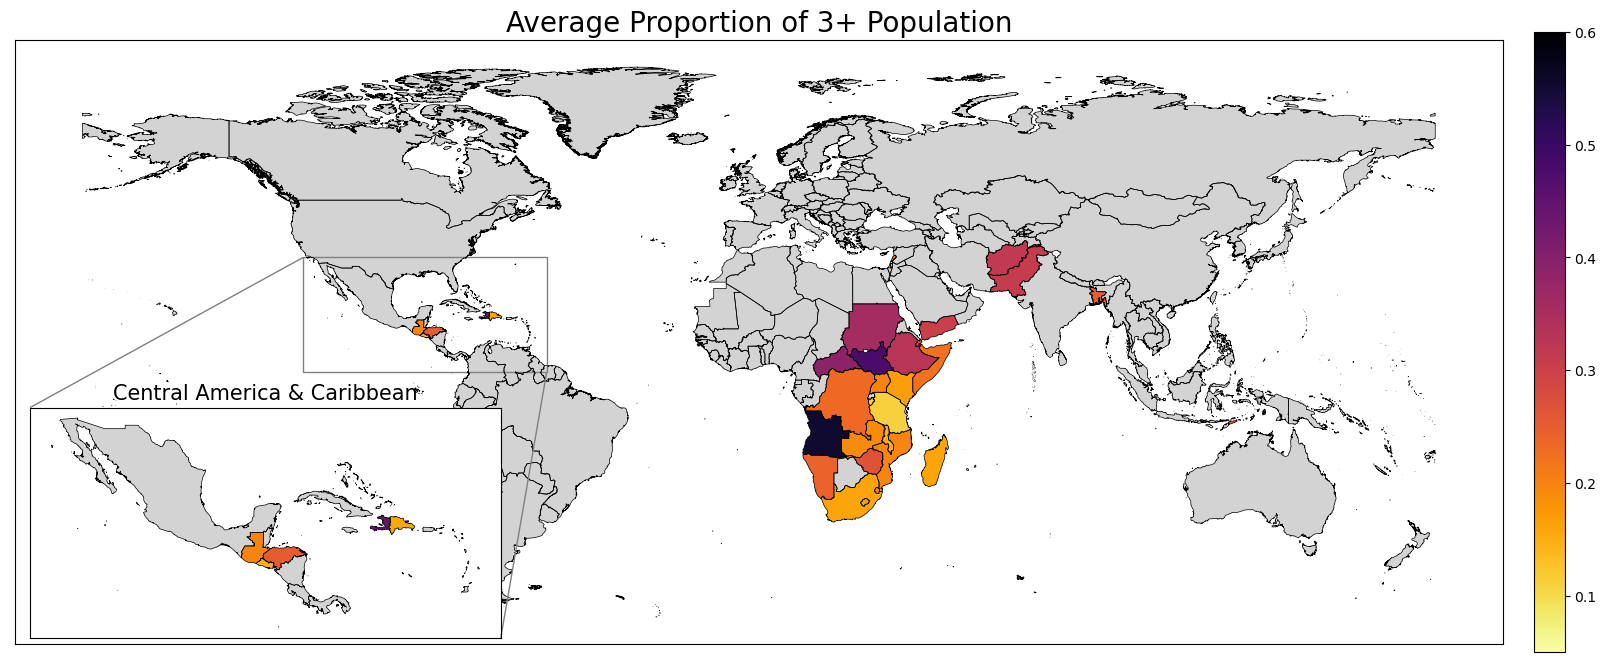

In [6]:
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Assuming 'worldgdf', 'country_min_ipc', and 'variable' are defined

fig, ax = plt.subplots(figsize=(20, 10))


variable = 'phase3plus_perc'

country_mean_ipc   = cleaned_ipc_df[cleaned_ipc_df['index'].isin([t[0] for t in cleaned_ipc_df.groupby('country_name')['index'].unique()])].groupby('countrycode')[['overall_phase','phase3plus_perc']].mean().reset_index().rename(columns = {'countrycode':'ISO_A3'})
country_max_ipc    = cleaned_ipc_df[cleaned_ipc_df['index'].isin([t[0] for t in cleaned_ipc_df.groupby('country_name')['index'].unique()])].groupby('countrycode')[['overall_phase','phase3plus_perc']].max().reset_index().rename(columns = {'countrycode':'ISO_A3'})
country_min_ipc    = cleaned_ipc_df[cleaned_ipc_df['index'].isin([t[0] for t in cleaned_ipc_df.groupby('country_name')['index'].unique()])].groupby('countrycode')[['overall_phase','phase3plus_perc']].min().reset_index().rename(columns = {'countrycode':'ISO_A3'})
country_median_ipc = cleaned_ipc_df[cleaned_ipc_df['index'].isin([t[0] for t in cleaned_ipc_df.groupby('country_name')['index'].unique()])].groupby('countrycode')[['overall_phase','phase3plus_perc']].median().reset_index().rename(columns = {'countrycode':'ISO_A3'})


# Prepare the merged GeoDataFrame
merged_worldgdf = worldgdf[['ISO_A3', 'geometry', 'SUBREGION']].merge(country_mean_ipc, on='ISO_A3', how='left')
merged_worldgdf['overall_phase'] = merged_worldgdf['overall_phase'].fillna(-1)

# Main plot with boundaries and variable-based coloring
merged_worldgdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
merged_worldgdf[merged_worldgdf['overall_phase']==-1].plot(column='overall_phase', ax=ax, legend=False, color='lightgray')

# Define a normalization for the variable's color scale
norm = mcolors.Normalize(vmin=0.05, vmax=0.60)

color_scheme = 'inferno_r'

# Plot the variable with consistent color mapping
cax = merged_worldgdf.plot(column=variable, ax=ax, cmap=color_scheme, norm=norm, legend=False, legend_kwds={'shrink': 0.5})

# Manually create a ScalarMappable for consistent color mapping
sm = plt.cm.ScalarMappable(cmap=color_scheme, norm=norm)
sm.set_array([])

# Colorbar for the main figure
cbar = fig.colorbar(sm, ax=ax, fraction=0.02, pad=0.02)

# Filter for Central America and the Caribbean
central_america_caribbean = merged_worldgdf[merged_worldgdf['SUBREGION'].isin(['Central America', 'Caribbean'])]

# Create a zoomed inset of the Central America and Caribbean region
axins = zoomed_inset_axes(ax, zoom=2, loc='lower left')
central_america_caribbean.boundary.plot(ax=axins, color='black', linewidth=0.5)
central_america_caribbean[central_america_caribbean['overall_phase']==-1].plot(column='overall_phase', ax=axins, legend=False, color='lightgray')

ax.set_title('Average Proportion of 3+ Population', fontsize = 20)
axins.set_title('Central America & Caribbean', fontsize = 15)

# Plot in the inset using the same ScalarMappable for color consistency
central_america_caribbean.plot(column=variable, ax=axins, cmap=color_scheme, norm=norm, legend = False)

# Set the geographical bounds for the zoomed inset
# These are placeholder values, adjust according to your data
# axins.set_xlim(-90, -60)
# axins.set_ylim(0, 20)

# Optionally, mark the inset to visually connect it to the main plot
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Hide the ticks of the inset axes to reduce clutter
ax.set_xticks([])
ax.set_yticks([])

axins.set_xticks([])
axins.set_yticks([])

plt.show()

In [7]:
# Create an array of values from 0 to 1 with a step size of 0.05, rounded to two decimal places
roundnumber = np.arange(0, 1, 0.05).round(2)

# Filter the DataFrame 'cleaned_ipc_df' to find rows where 'phase3plus_perc' is NOT in 'roundnumber'
notround_df = cleaned_ipc_df[~cleaned_ipc_df['phase3plus_perc'].isin(roundnumber)]
# Create an 'index' based on the combination of 'country_name' and 'yearmon' and add it to the DataFrame
notround_df['index'] = notround_df.set_index(['country_name', 'yearmon']).index
# Count the occurrences of the 'index' and reset the DataFrame, renaming 'index' column to 'count'
notround_df = notround_df['index'].value_counts().reset_index().rename(columns={'index': 'count'})

# Filter the DataFrame 'cleaned_ipc_df' to find rows where 'phase3plus_perc' IS in 'roundnumber'
round_df = cleaned_ipc_df[cleaned_ipc_df['phase3plus_perc'].isin(roundnumber)]
# Create an 'index' based on the combination of 'country_name' and 'yearmon' and add it to the DataFrame
round_df['index'] = round_df.set_index(['country_name', 'yearmon']).index
# Count the occurrences of the 'index' and reset the DataFrame, renaming 'index' column to 'count'
round_df = round_df['index'].value_counts().reset_index().rename(columns={'index': 'count'})

# Create a copy of 'round_df' for further comparison
merge_df = round_df.copy()  # 'notround_df' could also be compared here if desired

# Merge the 'total_notnulldf' with the 'merge_df' (which is 'round_df' here) on 'level_0'
compare_df = total_notnulldf.merge(merge_df, on='level_0')

# Calculate the ratio between the 'count' and 'index' columns to get the difference count
compare_df['diff_count'] = compare_df['count'] / compare_df['index']

# Filter for 'level_0' values where 'diff_count' is greater than or equal to 0.40
# Then extract unique 'level_0' values (potentially the names of countries or rounds)
compare_df[(compare_df['diff_count'] >= 0.40)]['level_0'].unique()

# Create an 'index' for 'all_df_notnull' based on 'country_name' and 'yearmon'
cleaned_ipc_df['index'] = cleaned_ipc_df.set_index(['country_name', 'yearmon']).index

# Filter 'all_df_notnull' where the 'index' matches the unique 'level_0' values 
# from 'compare_df' where 'diff_count' is greater than or equal to 0.95
# This gives a subset of the data where the majority of the classifications are rounded
plot_df = cleaned_ipc_df[cleaned_ipc_df['index'].isin(compare_df[(compare_df['diff_count'] >= 0.95)]['level_0'].unique())]

# Define the variable to be plotted ('phase3plus_perc')
var = 'phase3plus_perc'  # The percentage share of the population in Phase 3 or higher

In [8]:
rate = 0.50  # Set the threshold rate for filtering

# Filter the 'cleaned_ipc_df' based on whether 'index' is in the unique 'level_0' where 'diff_count' >= rate
matching_indices = compare_df[compare_df['diff_count'] >= rate]['level_0'].unique()

# Create two DataFrames: one where 'index' matches 'level_0' and one where it does not
rounded_df = cleaned_ipc_df[cleaned_ipc_df['index'].isin(matching_indices)].copy()     # Majority is Rounded Data
rounded_df_nr = cleaned_ipc_df[~cleaned_ipc_df['index'].isin(matching_indices)].copy() # Majority is Non-rounded Data

# Compute the 'phase3plus_product' by multiplying 'estimated_population' and 'phase3plus_perc'
rounded_df['phase3plus_product'] = rounded_df['estimated_population'] * rounded_df['phase3plus_perc']

# Output the lengths of the filtered DataFrames
print(len(rounded_df), len(rounded_df_nr))

9394 1496


## "rounded_df" (Sample A from Table A1) is the main df we are using for analysis.

# Figure 2. Comparison of observed and estimated distributions of IPC classifications, based on population shares in Phase 3+ (%). 

In [9]:
# Set Data and Key Parameters
np.random.seed(123)  # Set seed for reproducibility
num_simulations = 500  # Number of simulations to run
poly_degree = 4  # Degree of polynomial for fitting (4th degree as reference)
var = 'phase3plus_perc'  # Column name to be analyzed

# Prepare the Data
sub_df = rounded_df.copy()  # Copy the original dataframe for analysis
data = sub_df[f'{var}']  # Extract the data from the specified column
data_size = len(data)# // simulation_size_factor  # Define the size for each simulated dataset

# Step 1: Original Density Setup
zstar = 0.20  # Exclusion threshold value for bin filtering in simulations
binwidth = 0.05  # Width of each bin for histogramming data

# Create bins and bin midpoints for histogram calculations
bins_orig = np.arange(0, 1 + binwidth, binwidth)  # Define the bin edges for original data
binned_data_orig, _ = np.histogram(data.round(2), bins_orig.round(2))  # Histogram the original data
bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2  # Calculate midpoints of the original bins

# Create bins and midpoints for simulation purposes
bins = np.arange(0, 1 + binwidth, binwidth)  # Define bins for the simulations
bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)  # Calculate midpoints of the bins

############## Simulation 1 ##################

# Initialize arrays to store polynomial coefficients for each exclusion
coefficients_matrix_125 = np.zeros((num_simulations, 20))  # 10% excluded
coefficients_matrix_175 = np.zeros((num_simulations, 20))  # 15% excluded
coefficients_matrix_225 = np.zeros((num_simulations, 20))  # 20% excluded
coefficients_matrix_275 = np.zeros((num_simulations, 20))  # 25% excluded
coefficients_matrix_325 = np.zeros((num_simulations, 20))  # 30% excluded

# Define the bin_midpoints to exclude in each set of simulations
exclude_points = [0.175, 0.225, 0.275, 0.325]  # Exclude these midpoints one at a time

# Loop through the exclusion points and perform simulations
for k in range(len(exclude_points)):
    print('Excluded points: ', exclude_points[k] - 0.025)
    
    for j in range(num_simulations):
        # Simulate a subset of data
        simulated_data = data.sample(len(data))
        
        # Bin the simulated data
        binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))
        
        # Filter out the bin corresponding to the excluded point
        filtered_midpoints = bin_midpoints[bin_midpoints != exclude_points[k]]
        filtered_counts = binned_data[bin_midpoints != exclude_points[k]]
        
        # Polynomial fitting on the filtered data
        coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
        poly_func = np.poly1d(coefficients)  # Create polynomial function from coefficients
        
        # Generate points along the polynomial curve
        x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
        y_poly = poly_func(x_poly)
        
        # Set negative values to 0 for valid probability density
        y_poly = np.where(y_poly < 0, 0, y_poly)
        
        # Store the polynomial values in the corresponding matrix
        if k == 0:
            coefficients_matrix_175[j, :] = y_poly
        elif k == 1:
            coefficients_matrix_225[j, :] = y_poly
        elif k == 2:
            coefficients_matrix_275[j, :] = y_poly
        else:
            coefficients_matrix_325[j, :] = y_poly

    print('Filtered_midpoints: ', filtered_midpoints - 0.025)

# Combine coefficient matrices from all exclusions into a single 3D array
all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                     coefficients_matrix_275, coefficients_matrix_325))
#print(all_coefficients_matrix.shape)

# Compute mean of all coefficients across simulations
mean_coefficients1 = np.mean(all_coefficients_matrix, axis=0)

# Calculate standard devs for the coefficients
std_devs1 = np.std(all_coefficients_matrix, axis=0, ddof=1)

############## Simulation 2 ##################
num_simulations = num_simulations * 4 #To make the number of simulations comparable with bin-excluded #1 simulation

# Initialize an array for storing coefficients from Simulation 2
coefficients_matrix2 = np.zeros((num_simulations, 20))

# Perform the second set of simulations
for j in range(num_simulations):
    simulated_data = data.sample(len(data), replace = True)  # Simulate data sample
    #print('simul2:', len(data))
    binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))  # Bin the simulated data

    # Polynomial fitting
    coefficients = np.polyfit(bin_midpoints, binned_data, poly_degree)
    poly_func = np.poly1d(coefficients)
    x_poly = np.linspace(min(bin_midpoints), max(bin_midpoints), 20)
    y_poly = poly_func(x_poly)

    # Replace negative values with 0
    y_poly = np.where(y_poly < 0, 0, y_poly)
    
    coefficients_matrix2[j, :] = y_poly

#print('Simul 2: ', bin_midpoints - 0.025)
# Compute mean and standard devs for the second simulation

mean_coefficients2 = np.mean(coefficients_matrix2, axis=0)
std_devs2 = np.std(coefficients_matrix2, axis=0, ddof=1)

############## Simulation 3 ##################

# Initialize an array to store coefficients for Simulation 3
coefficients_matrix3 = np.zeros((num_simulations, 20))

# Perform the third simulation
for j in range(num_simulations):
    simulated_data = data.sample(len(data), replace = True)  # Simulate data sample
    binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))  # Bin the simulated data

    # Exclude bins around the threshold zstar
    filtered_midpoints = bin_midpoints[(bin_midpoints < zstar - binwidth) | (bin_midpoints > zstar + binwidth)]
    filtered_counts = binned_data[(bin_midpoints < zstar - binwidth) | (bin_midpoints > zstar + binwidth)]
    
    # Polynomial fitting on filtered data
    coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
    poly_func = np.poly1d(coefficients)
    x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
    y_poly = poly_func(x_poly)

    # Replace negative values with 0
    y_poly = np.where(y_poly < 0, 0, y_poly)

    coefficients_matrix3[j, :] = y_poly

# Compute mean and standard devs for the third simulation
mean_coefficients3 = np.mean(coefficients_matrix3, axis=0)
std_devs3 = np.std(coefficients_matrix3, axis=0, ddof=1)

Excluded points:  0.15
Filtered_midpoints:  [0.   0.05 0.1  0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.2
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.25
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.3
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.25 0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


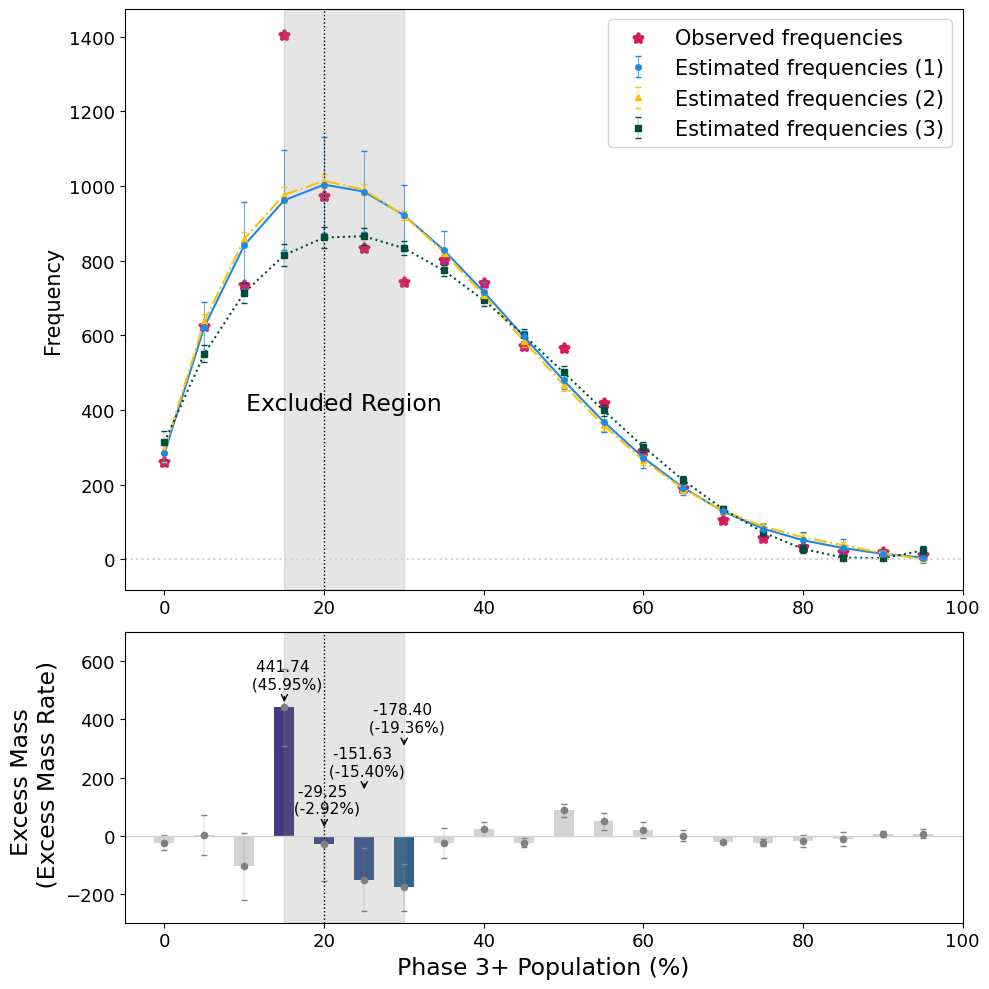

In [10]:
# Create a DataFrame directly from a dictionary
agg_df = pd.DataFrame({
    'bins': bin_midpoints - 0.025,
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_devs': std_devs1
})

agg_df['excess_mass'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])
agg_df['excess_mass_perc'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])/agg_df['mean_coefficients']


# Create subplots
fig, axs = plt.subplots(2,1, figsize = (10,10), gridspec_kw={'height_ratios': [2, 1]})
#fig.subplots_adjust(wspace=0.5) 

# Plot on the first subplot
handle0 = axs[0].scatter(bin_midpoints_orig-0.025, binned_data_orig, label="Binned Data", color='#D81B60', marker='*', linewidth=3)

# Plot on the second subplot

# First, store each errorbar call in a variable to create custom handles
handle3 = axs[0].errorbar(bin_midpoints-0.025, mean_coefficients3, yerr=std_devs3*2, fmt='s', markersize=4, 
                color='#004D40', ecolor='#004D40', elinewidth=0.2, capsize=2)
handle2 = axs[0].errorbar(bin_midpoints-0.025, mean_coefficients2, yerr=std_devs2*2, fmt='^', markersize=4,
                color='#FFC107', ecolor='#FFC107', elinewidth=0.2, capsize=2)
handle1 = axs[0].errorbar(bin_midpoints-0.025, mean_coefficients1, yerr=std_devs1*2, fmt='o', markersize=4,
                color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2)

# Now create the legend explicitly with the desired order
axs[0].legend([handle0, handle1, handle2, handle3], 
              [f'Observed frequencies', 
                f'Estimated frequencies (1)', 
               f'Estimated frequencies (2)', 
               f'Estimated frequencies (3)'
              ], loc="upper right", ncol=1, fontsize=15)

axs[0].plot(bin_midpoints-0.025, mean_coefficients1, color='#1E88E5',)
axs[0].plot(bin_midpoints-0.025, mean_coefficients2, color='#FFC107', linestyle = '-.')
axs[0].plot(bin_midpoints-0.025, mean_coefficients3, color='#004D40', linestyle = ':')
axs[0].axvline(x=0.20, color='black', alpha=1, linestyle=':', linewidth = 1)
axs[0].axhline(y=0.0, color='lightgray', linestyle = ':')


# Adjust x-ticks if needed (commented out as there's no clear definition for `locations`)
axs[0].axvspan(0.15, 0.30, color='gray', alpha=0.2)
locations = np.arange(0, 1.2, 0.2) 
axs[0].set_xticks(locations)
axs[0].set_xticklabels(np.arange(0, 120, 20))
axs[0].set_xlim([-0.05, 1.0])
axs[0].annotate(f"Excluded Region", (0.225, 400), ha = 'center', fontsize = 17)

##################################################################3
x_range = [0.15, 0.20, 0.25, 0.30]
x_beg = 4
x_end = 8

########### AXS1

# Generate colors based on condition
colors = ['viridis_r' if x in x_range else 'gray' for x in agg_df['bins']]

# Ensure the 'bins' variable is categorical for better control over the barplot
agg_df['bins'] = pd.Categorical(agg_df['bins'], categories=np.sort(agg_df['bins'].unique()), ordered=True)

# Create a normalizer object which will map the data values (mean_coefficients1) to the range [0,1] for color mapping
actual_colors = [to_hex(viridis(np.linspace(0, 1, len(colors))[i])) if color == 'viridis_r' else 'lightgray' for i, color in enumerate(colors)]

# Bar plot
axs[1].bar(agg_df['bins'], agg_df['excess_mass'], width = 0.025, color = actual_colors)
axs[1].errorbar(agg_df['bins'], agg_df['excess_mass'], yerr=agg_df['std_devs']*2, 
                fmt='o', color='gray', elinewidth=0.2, capsize=2, markersize = 4.5)

axs[1].axvline(x= 0.2, color = 'black', linestyle = ':', linewidth = 1)
axs[1].axhline(y= 0, color = 'lightgray', linewidth = 1)

np.random.seed(20)

agg_df['y_loc'] = [0,0,0,450, 20, 150, 300, 0,0,0,0,0,0,0,0,0,0,0, 0,0 ]
agg_df['x_loc'] = [0,0,0,0.15, 0.20, 0.225, 0.335, 0,0,0,0,0,0,0,0,0,0,0, 0,0 ]

for p, bin_val, perc, x, y in zip(axs[1].patches, agg_df['bins'], agg_df['excess_mass_perc'], agg_df['x_loc'], agg_df['y_loc']):
    # Check if the current bar is in the special range
    if bin_val in x_range:
        # Jitter: random small adjustments in the x position
        jitter_w = np.random.uniform(-1, 1) * 0.5 * p.get_width()  # Jitter calculation
        jitter_h = np.random.uniform(-1, 1) * 0.5 * p.get_height()  # Jitter calculation
        # Annotate with an arrow
        axs[1].annotate(
            f"{p.get_height():.2f} \n ({perc*100:.2f}%)",  # Text
            xy=(p.get_x() + p.get_width() / 2, y),  # Point to annotate
            xytext=(0.5, 10),  # Position of text relative to point
            textcoords="offset points",
            ha='center',
            va='bottom',
            color='black',
            fontsize=11,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))  # Arrow style

axs[1].set_xlabel('Phase 3+ Population (%)', fontsize=17)
axs[1].set_ylabel('Excess Mass \n (Excess Mass Rate)', fontsize = 17)

# Adjust x-ticks if needed (commented out as there's no clear definition for `locations`)
axs[1].axvspan(0.15, 0.30, color='gray', alpha=0.2)
locations = np.arange(0, 1.2, 0.2) 
axs[1].set_xticks(locations)
axs[1].set_xticklabels(np.arange(0, 120, 20))
axs[0].tick_params(axis='y', labelsize=13) 
axs[1].tick_params(axis='y', labelsize=13)
axs[0].tick_params(axis='x', labelsize=13)
axs[1].tick_params(axis='x', labelsize=13)
axs[0].set_ylabel('Frequency', fontsize=15)
axs[1].set_ylim([-300, 700])
axs[1].set_xlim([-0.05, 1.0])

plt.tight_layout()
plt.show()
plt.show()      

# Figure 2 Continue: Country Level Bunching

(Afghanistan, 2017-08)    34
(Afghanistan, 2018-08)    34
(Afghanistan, 2019-08)    34
(Afghanistan, 2020-04)    45
(Afghanistan, 2020-08)    45
(Afghanistan, 2021-03)    45
(Afghanistan, 2021-09)    45
(Afghanistan, 2022-03)    45
(Afghanistan, 2022-09)    45
(Afghanistan, 2023-04)    45
(Afghanistan, 2023-10)    45
Name: index, dtype: int64
Country and Sample size per country:  462
Checking if excluded bins are excluded properly:  [0.   0.05 0.1  0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Checking if excluded bins are excluded properly:  [0.   0.05 0.1  0.15 0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Checking if excluded bins are excluded properly:  [0.   0.05 0.1  0.15 0.2  0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Checking if excluded bins are excluded properly:  [0.   0.05 0.1  0.15 0.2  0.25 0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
(Congo, DRC, 2018-08)    

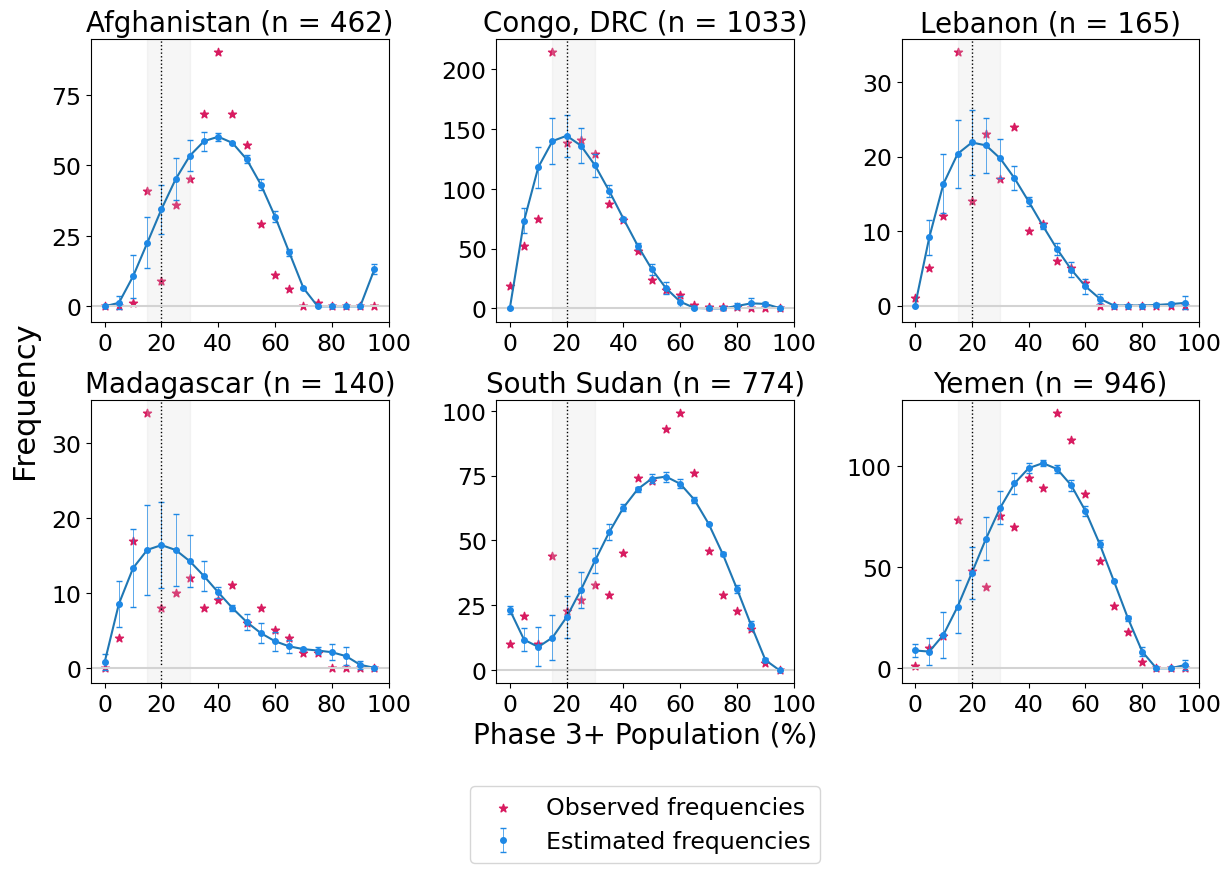

In [11]:
# Set the variable to analyze
var = 'phase3plus_perc'  # Column containing the percentage of the population in Phase 3 or higher

# List of countries to analyze, sorted alphabetically
countries = sorted(['Afghanistan', 'Congo, DRC', 'Madagascar', 'South Sudan', 'Yemen', 'Lebanon'])

# Set the number of Monte Carlo simulations to run and the degree of polynomial for fitting
num_simulations = 500  # Number of simulations
poly_degree = 4  # Degree of polynomial

# Create a grid of subplots for each country (2 rows and 3 columns)
fig, axes = plt.subplots(len(countries)//3, 3, figsize=(12, 9))

# Initialize an empty list to store aggregated data
agg = []

# List of areas in Kenya to exclude from analysis
no_kenya = ['KAWANGWARE', 'MUKURU', 'GITHURAI', 'KANGEMI', 'KAYOLE', 'BANGLADESH', 'DANDORA', 
            'OBUNGA', 'KONDELE', 'KIBRA', 'MWEMBE TAYARI', 'MATHARE']

# Indexes to exclude from analysis due to unusual data patterns (optional)
exclude_index = []  # Add indices if needed, e.g., [('Afghanistan', '2019-08')]

# Loop through each country
for i, c in enumerate(sorted(countries)):
    # Filter the data for the current country, excluding specified areas and indexes
    sub_df = rounded_df[(rounded_df['country_name'] == c) & 
                     ~(rounded_df['Area'].isin(no_kenya)) & 
                     ~(rounded_df['index'].isin(exclude_index))]
    
    # Check the number of unique assessments (observations) per round for each country
    print(sub_df['index'].value_counts().sort_index())

    # Extract the data for 'phase3plus_perc' to be used in the analysis
    data = sub_df[f'{var}']
    
    # Output the sample size for the current country
    print('Country and Sample size per country: ', len(data))
    
    # Set the parameters for the Monte Carlo simulation
    np.random.seed(1234)  # Seed for reproducibility
    data_size = len(data)  # Size of the data sample

    # Define binwidth and bin midpoints for histogram calculations
    binwidth = 0.05
    bins = np.arange(0, 1 + binwidth, binwidth)
    bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)
    
    # Initialize arrays to store coefficients from each set of simulations
    coefficients_matrix_125 = np.zeros((num_simulations, 20))
    coefficients_matrix_175 = np.zeros((num_simulations, 20))
    coefficients_matrix_225 = np.zeros((num_simulations, 20))
    coefficients_matrix_275 = np.zeros((num_simulations, 20))
    coefficients_matrix_325 = np.zeros((num_simulations, 20))
    
    # Define the bin midpoints to exclude in each simulation
    exclude_points = [0.175, 0.225, 0.275, 0.325]
    
    # Run simulations for each exclusion point
    for k in range(len(exclude_points)):
        
        for j in range(num_simulations):
            # Randomly sample data for the simulation
            simulated_data = data.sample(data_size)

            # Bin the simulated data
            binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))

            # Exclude certain midpoints from the binning process
            filtered_midpoints = bin_midpoints[bin_midpoints != exclude_points[k]]
            filtered_counts = binned_data[bin_midpoints != exclude_points[k]]

            # Fit a polynomial curve to the binned data
            coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
            poly_func = np.poly1d(coefficients)

            # Generate points along the fitted polynomial
            x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
            y_poly = poly_func(x_poly)
            
            # Replace negative values with 0 for valid probability density
            y_poly = np.where(y_poly < 0, 0, y_poly)

            # Store the fitted polynomial values in the corresponding matrix
            if k == 0:
                coefficients_matrix_175[j, :] = y_poly
            elif k == 1:
                coefficients_matrix_225[j, :] = y_poly
            elif k == 2:
                coefficients_matrix_275[j, :] = y_poly
            else:
                coefficients_matrix_325[j, :] = y_poly

        # Output a check to ensure excluded bins are correctly handled
        print('Checking if excluded bins are excluded properly: ', filtered_midpoints - 0.025)

    # Concatenate all the coefficient matrices into one array
    all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                         coefficients_matrix_275, coefficients_matrix_325))
    
    # Calculate the mean and standard deviations of the fitted coefficients
    mean_coefficients = np.mean(all_coefficients_matrix, axis=0)
    std_devs = np.std(all_coefficients_matrix, axis=0, ddof=1)

    # Determine subplot position for the current country
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # Step 1: Compute the original density histogram
    bins_orig = np.arange(0, 1 + binwidth, binwidth)
    binned_data_orig, _ = np.histogram(data.round(2), bins_orig.round(2))
    bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2

    # Plot the original binned data (observed frequencies)
    ax.scatter(bin_midpoints_orig - 0.025, binned_data_orig, label="Binned Data", color='#D81B60', marker='*')

    # Plot the simulated data with error bars (mean coefficients ± 2 * standard deviation)
    ax.errorbar(bin_midpoints - 0.025, mean_coefficients, yerr=std_devs*2,
                fmt='o', color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2, markersize=4)
    
    # Add title to each subplot with the country name and sample size
    ax.set_title(f'{c} (n = {len(sub_df)})', fontsize=20)

    # Add a legend and x-label only in the middle subplot
    if (row == 1) & (col == 1):
        ax.legend([f'Observed frequencies', f'Estimated frequencies'], 
                  bbox_to_anchor=(0.5, -0.5), ncol=1, loc="center", fontsize=17)
        ax.set_xlabel('Phase 3+ Population (%)', fontsize=20)

    # Plot the fitted polynomial line on top of the scatter plot
    ax.plot(bin_midpoints - 0.025, mean_coefficients)

    # Add vertical and horizontal reference lines to highlight certain regions
    ax.axvline(x=0.20, color='black', alpha=1, linestyle=':', linewidth=1)
    ax.axvspan(0.15, 0.30, color='lightgray', alpha=0.2)
    ax.axhline(y=0.0, color='lightgray')

    # Set the x-ticks and format them as percentages
    ax.set_xticks(np.arange(0, 1.05, 0.2))
    ax.set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])

    # Create a DataFrame to store the aggregated data for later analysis
    agg_df = pd.DataFrame({
        'bins': bin_midpoints - 0.025,
        'binned_data_orig': binned_data_orig,
        'mean_coefficients': mean_coefficients
    })

    # Calculate excess mass (difference between observed and simulated frequencies)
    agg_df['excess_mass'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients']) / agg_df['mean_coefficients']
    agg_df['country'] = c
    agg.append(agg_df)  # Append the data for this country to the 'agg' list

    # Adjust axis tick labels
    ax.tick_params(axis='y', labelsize=17)
    ax.tick_params(axis='x', labelsize=17)

# Optimize the layout to avoid overlapping of plots
plt.tight_layout()

# Add labels for the overall figure
fig.text(-0.01, 0.55, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=22)

# Display the plot
plt.show()


# Figure 3 to 5 rely on IPC data with confidential underlying indicators

In [12]:
# Load Subset of IPC data that has underlying indicators
ipc_df_sub = pd.read_csv(home+r'\stores\data\ipc_sample_c.csv')

ipc_df_sub = ipc_df_sub[ipc_df_sub['FSI_combination'].isin(['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS'])]

# Create ISO country_codes for easy merge
country_codes_updated = {
    'Madagascar': 'Madagascar',
    'Ethiopia': 'Ethiopia',
    'Djibouti': 'Djibouti',
    'Lebanon': 'Lebanon',
    'Kenya': 'Kenya',
    'Haiti': 'Haiti',
    'Guatemala': 'Guatemala',
    'Yemen': 'Yemen',
    'Pakistan': 'Pakistan',
    'Mozambique': 'Mozambique',
    'South Sudan': 'South Sudan',
    'DR Congo': 'Congo, DRC',  # DR Congo refers to Democratic Republic of the Congo
    'CAR': 'Central African Republic',  # CAR refers to Central African Republic
    'Afghanistan': 'Afghanistan',
    'Sudan': 'Sudan'
}

ipc_df_sub['country_name'] = ipc_df_sub['country'].replace(country_codes_updated)

ipc_df_sub['index'] = ipc_df_sub.set_index(['country_name','yearmon']).index


In [13]:
# Define a function to round a number to the nearest multiple of 5
def round_to_nearest_5(num):
    return np.round(num / 5) * 5  # Directly apply the rounding operation

# Apply the rounding function to multiple columns in the DataFrame in one step
cols_to_round = ['phase3_plus', 'FCS_3plus', 'rCSI_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus']

# Apply the function to each column in the list
for col in cols_to_round:
    # Multiply by 100 to get percentages, round to nearest 5, then divide by 100 to convert back
    ipc_df_sub[f'{col}_up'] = round_to_nearest_5(ipc_df_sub[col] * 100) / 100


# Figure 3: Comparisons of distributions of IPC assessments defined by proportion of population in phase 3+ (Observed vs Counterfactual)

In [14]:
## Creating Counterfactual measures per area assessment

# Worst FSI 3+
ipc_df_sub['worst_fsi'] = ipc_df_sub[['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 
                                        'lcs_3plus_up', 'hdds_3plus_up']].max(axis = 1)

ipc_df_sub['average_3plus'] = ipc_df_sub[['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 
                                        'lcs_3plus_up', 'hdds_3plus_up']].mean(axis = 1)

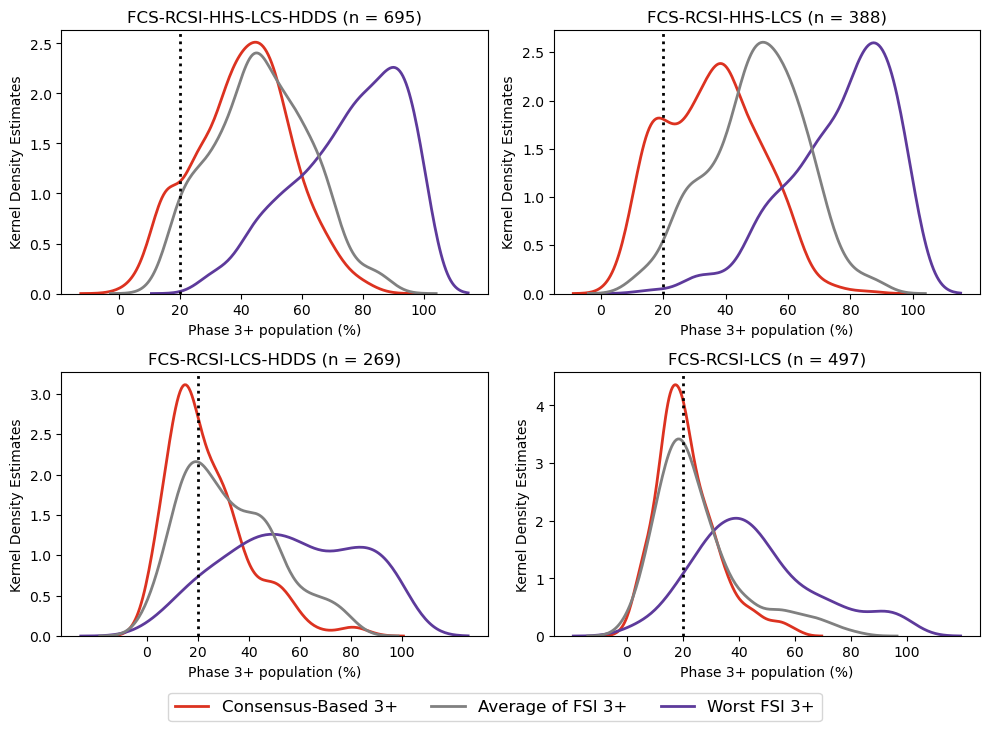

In [15]:
# Get unique FSI_combination values
unique_combinations = ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS','FCS-RCSI-LCS']

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

# Iterate over unique combinations and plot in subplots
for i, g in enumerate(unique_combinations):
    row = i // 2  # Calculate the row index
    col = i % 2   # Calculate the column index
    # Ensuring the plot order matches the desired legend order
    sns.kdeplot(ipc_df_sub[ipc_df_sub['FSI_combination'] == g]['phase3_plus'], ax=ax[row, col], linewidth=2, color='#DC3220', label='Average of FSI 3+')
    sns.kdeplot(ipc_df_sub[ipc_df_sub['FSI_combination'] == g]['worst_fsi'], ax=ax[row, col], linewidth=2, color='#5D3A9B', label='Worst FSI 3+')
    sns.kdeplot(ipc_df_sub[ipc_df_sub['FSI_combination'] == g]['average_3plus'], ax=ax[row, col], linewidth=2, color='gray', label='Consensus-Based 3+')
    
    ax[row, col].set_title(f"{g} (n = {len(ipc_df_sub[ipc_df_sub['FSI_combination'] == g])})")
    #ax[row, col].legend(['Average of FSI 3+','Worst FSI 3+', 'Consensus-Based 3+'], bbox_to_anchor = (0.5,0.05), ncol = 3,  fontsize=10)
    ax[row, col].set_xlabel('Phase 3+ population (%)')
    ax[row, col].set_ylabel('Kernel Density Estimates')
    ax[row, col].grid(False)
    
    ax[row, col].axvline(x=0.2, color='black',  linewidth = 2, linestyle = ':')

    # Formatting tick labels
    ax[row, col].set_xticks(np.arange(0, 1.05, 0.2))  # Set ticks from 0 to 1 by 0.2
    ax[row, col].set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])  # Optional: Format labels to 2 decimal places


# Remove any remaining empty subplots
for i in range(len(unique_combinations), 4):
    row = i // 2
    col = i % 2
    fig.delaxes(ax[row, col])

plt.tight_layout()
# Place legend below the subplots
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend([handles[0], handles[2], handles[1]], ['Consensus-Based 3+', 'Average of FSI 3+','Worst FSI 3+'], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
plt.show()


# Figure 4. Distribution of the difference between consensus-based 3+ population (%) and the arithmetic mean of FSI implied 3+ populations (%) for IPC assessments

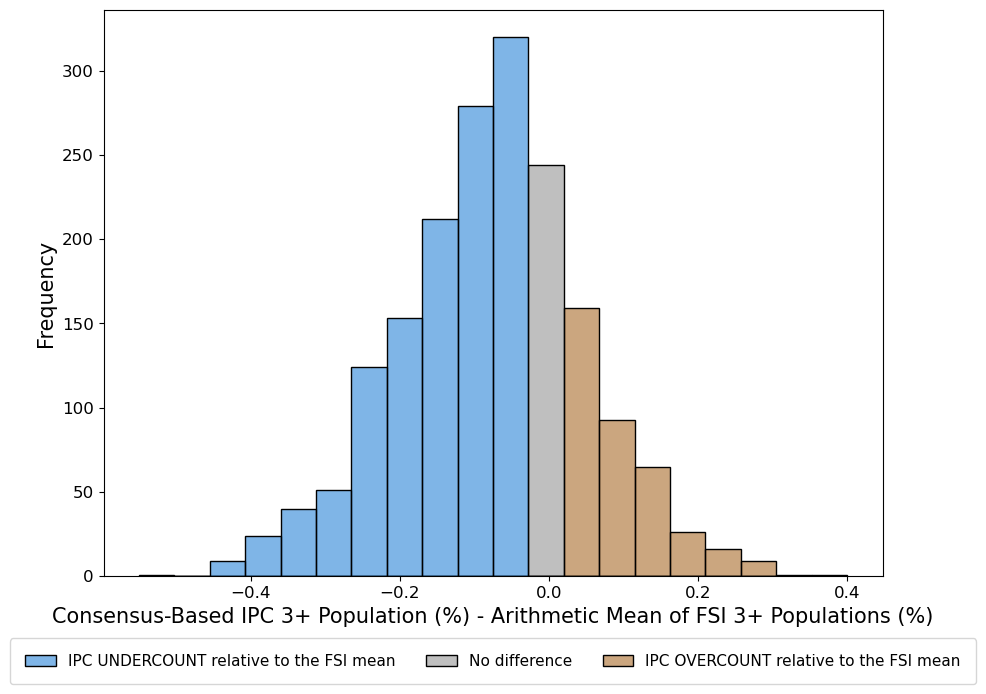

In [16]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))

df = ipc_df_sub[ipc_df_sub['FSI_combination']!='FCS-RCSI-HHS-HDDS'].copy()
#y-axis
df['diff']    = (df['phase3_plus_up'] - df['average3_up']).round(2)
df['diff_abs']= (abs(df['phase3_plus_up'] - df['average3_up'])).round(2)

# X-axis
fsi_set = ['FCS_3plus_up',
 'rCSI_3plus_up',
 'hhs_3plus_up',
 'lcs_3plus_up',
 'hdds_3plus_up']

df['diff_minmax'] = (df[fsi_set].max(axis = 1) - df[fsi_set].min(axis = 1)).round(2)
df['fi_sd'] = (df[fsi_set].std(axis = 1)).round(2)

df['obs-avg'] = np.where(df['diff']>0,'positive','negative')
df['obs-avg'] = np.where(df['diff']==0,'no difference',df['obs-avg'])


sns.histplot(df, x = 'diff', 
             hue = 'obs-avg',ax = ax,
             bins = len(set(sorted(df['diff'].unique().round(2)))), palette = {'positive':'#994F00',
                                                                               'no difference':'gray',
                                                                               'negative':'#006CD1'})
def capture_legend(ax, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    return handles, labels

handles, labels = capture_legend(ax)

# Since we know the labels, we can directly specify the desired order
desired_order = ['negative','no difference', 'positive']
desired_labels = ['IPC UNDERCOUNT relative to the FSI mean', 'No difference','IPC OVERCOUNT relative to the FSI mean']

# Filter handles based on the desired order (matching labels to desired labels, in case they're not captured)
ordered_handles = [handles[labels.index(label)] for label in desired_order if label in labels]

# Update the legend
ax.legend(handles=ordered_handles, 
          labels=desired_labels, 
          bbox_to_anchor=(0.5, -0.15), 
          ncol=3, borderpad=1, loc='center', fontsize=11, title=False)

ax.set_xlabel('Consensus-Based IPC 3+ Population (%) - Arithmetic Mean of FSI 3+ Populations (%)', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)

for label in ax.get_xticklabels():
    label.set_fontsize(12)
for label in ax.get_yticklabels():
    label.set_fontsize(12)

ax.grid(False)
plt.tight_layout()
#handles, ordered_handles


# Figure 5. Number of undercounted populations in phase 3+ using counterfactual distributions estimates by FSI availability group

In [17]:
# List to store results
results = []

for g in ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS']:
    
    for i in ['phase3_plus','average_3plus', 'worst_fsi']:
        
        # Filter the DataFrame based on the condition
        plot_df = ipc_df_sub[(ipc_df_sub['FSI_combination'].isin(['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS']))]
        # Calculate the required values
        counter_three_plus = (plot_df[i] * plot_df['estimated_population']).sum() / 1000000
        observed_three_plus = (plot_df['phase3_plus'] * plot_df['estimated_population']).sum() / 1000000
        total = plot_df['estimated_population'].sum() / 1000000
        ratio = (counter_three_plus / observed_three_plus)*100
        

        # Store the results in a dictionary and append to the list
        results.append({
            'FSI_combination': g,
            'Column': i,
            'Counter_ThreePlus_Millions': counter_three_plus,
            'observed_3plusPop_Millions': observed_three_plus,
            'total': total,
            'Ratio': ratio
        })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

results_df['Diff_3plusPop_Millions'] = abs(results_df['observed_3plusPop_Millions'] - results_df['Counter_ThreePlus_Millions'] )
results_df['Ratio'] = (results_df['Diff_3plusPop_Millions'] / results_df['observed_3plusPop_Millions']) *100

# Display the DataFrame
results_df


,FSI_combination,Column,Counter_ThreePlus_Millions,observed_3plusPop_Millions,total,Ratio,Diff_3plusPop_Millions
0,FCS-RCSI-HHS-LCS-HDDS,phase3_plus,226.490665,226.490665,742.667852,0.000000,0.000000
1,FCS-RCSI-HHS-LCS-HDDS,average_3plus,292.902579,226.490665,742.667852,29.322142,66.411914
2,FCS-RCSI-HHS-LCS-HDDS,worst_fsi,487.701934,226.490665,742.667852,115.329817,261.211269
3,FCS-RCSI-HHS-LCS,phase3_plus,226.490665,226.490665,742.667852,0.000000,0.000000
4,FCS-RCSI-HHS-LCS,average_3plus,292.902579,226.490665,742.667852,29.322142,66.411914
5,FCS-RCSI-HHS-LCS,worst_fsi,487.701934,226.490665,742.667852,115.329817,261.211269
6,FCS-RCSI-LCS-HDDS,phase3_plus,226.490665,226.490665,742.667852,0.000000,0.000000
7,FCS-RCSI-LCS-HDDS,average_3plus,292.902579,226.490665,742.667852,29.322142,66.411914
8,FCS-RCSI-LCS-HDDS,worst_fsi,487.701934,226.490665,742.667852,115.329817,261.211269
9,FCS-RCSI-LCS,phase3_plus,226.490665,226.490665,742.667852,0.000000,0.000000


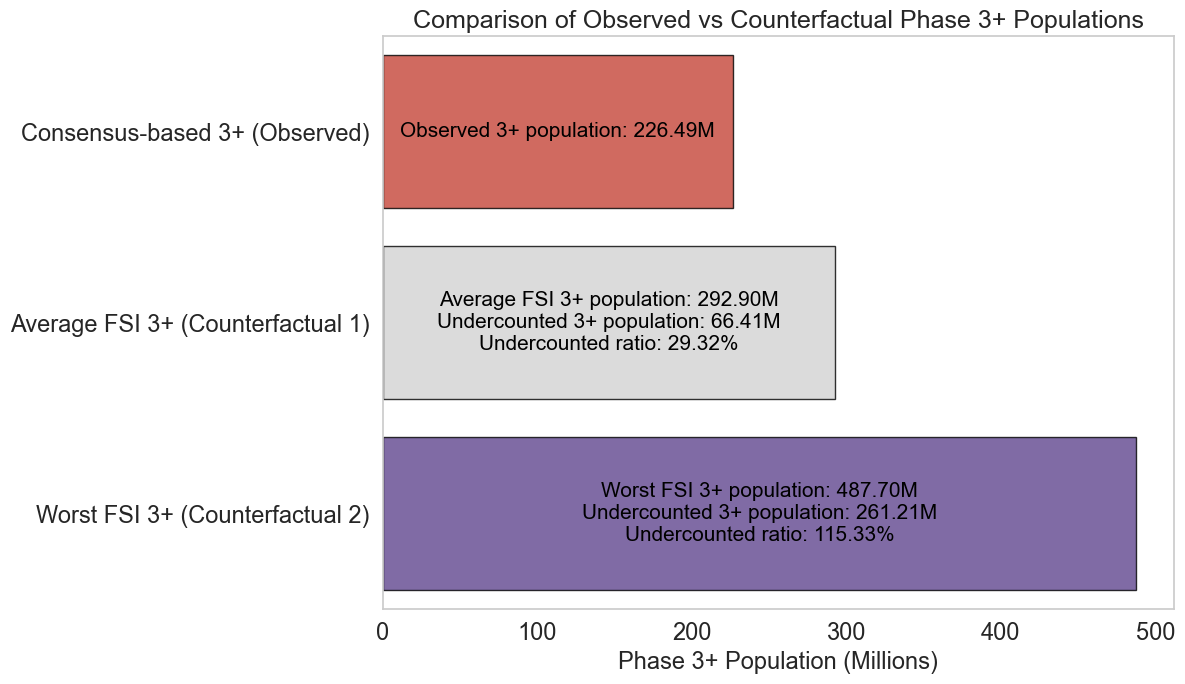

In [18]:
# Set the style and context
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

# Plotting the counterfactual data without repetitive annotations
ax = sns.barplot(y='Column', x='Counter_ThreePlus_Millions',
                 data=results_df, palette=['#DC3220', 'lightgray', '#5D3A9B'], edgecolor='black', orient='h', alpha=0.8)

# Annotate only the most important point: Observed Population
ax.text(results_df.loc[0, 'Counter_ThreePlus_Millions'] / 2, 0,
        f"Observed 3+ population: {results_df.loc[0, 'observed_3plusPop_Millions']:.2f}M",
        color='black', ha="center", va="center", fontsize=15)

# Annotate Average FSI population only once
ax.text(results_df.loc[1, 'Counter_ThreePlus_Millions'] / 2, 1,
        f"Average FSI 3+ population: {results_df.loc[1, 'Counter_ThreePlus_Millions']:.2f}M\n"
        f"Undercounted 3+ population: {results_df.loc[1, 'Diff_3plusPop_Millions']:.2f}M\n"
        f"Undercounted ratio: {results_df.loc[1, 'Ratio']:.2f}%",
        color='black', ha="center", va="center", fontsize=15)

# Annotate Worst FSI population only once
ax.text(results_df.loc[2, 'Counter_ThreePlus_Millions'] / 2, 2,
        f"Worst FSI 3+ population: {results_df.loc[2, 'Counter_ThreePlus_Millions']:.2f}M\n"
        f"Undercounted 3+ population: {results_df.loc[2, 'Diff_3plusPop_Millions']:.2f}M\n"
        f"Undercounted ratio: {results_df.loc[2, 'Ratio']:.2f}%",
        color='black', ha="center", va="center", fontsize=15)

# Remove unnecessary ylabel and adjust xlabel
ax.set_ylabel('')
ax.set_xlabel('Phase 3+ Population (Millions)', fontsize=17)
ax.tick_params(axis='x', labelsize=17)

# Customize y-ticks with more descriptive labels
new_labels = ['Consensus-based 3+ (Observed)', 'Average FSI 3+ (Counterfactual 1)', 'Worst FSI 3+ (Counterfactual 2)']
ax.set_yticklabels(new_labels, fontsize=17)

# Add a title to the plot
plt.title('Comparison of Observed vs Counterfactual Phase 3+ Populations', fontsize=18)

# Tidy up the plot
plt.tight_layout()
plt.grid(False)  # Disable grid lines
plt.show()


# Tables & Figures in the Supplement Information

## Table A1: Description of the sample

In [19]:
# Calculate product for each DataFrame
rounded_df['product'] = rounded_df['estimated_population'] * rounded_df['phase3plus_perc']
rounded_df_nr['product'] = rounded_df_nr['estimated_population'] * rounded_df_nr['phase3plus_perc']
ipc_df_sub['product'] = ipc_df_sub['estimated_population'] * ipc_df_sub['phase3_plus']

# Create a summary DataFrame for each dataset
summary_data = {
    'Dataset': ['Sample A', 'Sample B', 'Sample C'],
    'Yearmon Min': [
        rounded_df['yearmon'].min(),
        rounded_df_nr['yearmon'].min(),
        ipc_df_sub['yearmon'].min()
    ],
    'Yearmon Max': [
        rounded_df['yearmon'].max(),
        rounded_df_nr['yearmon'].max(),
        ipc_df_sub['yearmon'].max()
    ],
    'Unique Countries': [
        rounded_df['country_name'].nunique(),
        rounded_df_nr['country_name'].nunique(),
        ipc_df_sub['country_name'].nunique()
    ],

    'Unique TWG Meetings': [
        rounded_df['index'].nunique(),
        rounded_df_nr['index'].nunique(),
        ipc_df_sub['index'].nunique()
    ],
    'Unique Countries': [
        rounded_df['country_name'].nunique(),
        rounded_df_nr['country_name'].nunique(),
        ipc_df_sub['country_name'].nunique()
    ],
    'Total Rows': [
        len(rounded_df),
        len(rounded_df_nr),
        len(ipc_df_sub)
    ],
    'Phase 3+ Count': [
        len(rounded_df[rounded_df['overall_phase'] >= 3]),
        len(rounded_df_nr[rounded_df_nr['overall_phase'] >= 3]),
        len(ipc_df_sub[ipc_df_sub['overall_phase'] >= 3])
    ],
    'Estimated Population (millions)': [
        rounded_df['estimated_population'].sum() / 1_000_000,
        rounded_df_nr['estimated_population'].sum() / 1_000_000,
        ipc_df_sub['estimated_population'].sum() / 1_000_000
    ],
    'Product (millions)': [
        rounded_df['product'].sum() / 1_000_000,
        rounded_df_nr['product'].sum() / 1_000_000,
        ipc_df_sub['product'].sum() / 1_000_000
    ]
}

# Create a DataFrame to display the summary
summary_df = pd.DataFrame(summary_data)

# Print the resulting table
summary_df


,Dataset,Yearmon Min,Yearmon Max,Unique Countries,Unique TWG Meetings,Total Rows,Phase 3+ Count,Estimated Population (millions),Product (millions)
0,Sample A,2017-01,2023-10,33,172,9394,6362,2803.965941,730.724744
1,Sample B,2017-01,2023-03,20,45,1496,490,461.169744,70.422047
2,Sample C,2020-10,2022-11,15,27,1849,1387,742.667852,226.490665


# Table A2. Summary Statistics – Sample A from Table A1

In [20]:
# Calculate product for the 'rounded_df'
rounded_df['product'] = rounded_df['estimated_population'] * rounded_df['phase3plus_perc']

# Group by 'country_name' and calculate the required statistics
summary_by_country = rounded_df.groupby('country_name').agg(
    unique_twg=('index', pd.Series.nunique),  # Unique 'index' count
    unique_classifications=('overall_phase', lambda x: x.count()),  # Count where 'overall_phase' >= 3
    Estimated_Population_Millions=('estimated_population', lambda x: x.sum() / 1_000_000),  # Sum of population in millions
    Yearmon_Min=('yearmon', 'min'),  # Minimum year-month
    Yearmon_Max=('yearmon', 'max'),  # Maximum year-month
    Total_Rows=('index', 'size'),  # Total number of rows
    Product_Millions=('product', lambda x: x.sum() / 1_000_000),  # Sum of 'product' in millions
    average_Phase=('overall_phase', lambda x: x.mean()),  # Count where 'overall_phase' >= 3
    threeplus_perc=('phase3plus_perc', lambda x: x.mean()*100),  # Count where 'overall_phase' >= 3
).reset_index()


# Display the summary table
summary_by_country


,country_name,unique_twg,unique_classifications,Estimated_Population_Millions,Yearmon_Min,Yearmon_Max,Total_Rows,Product_Millions,average_Phase,threeplus_perc
0,Afghanistan,11,462.0,387.302149,2017-08,2023-10,462,146.330984,3.043290,38.326840
1,Angola,1,17.0,2.667790,2021-06,2021-06,17,1.315532,3.294118,55.294118
2,Bangladesh,1,17.0,38.236840,2023-03,2023-03,17,8.906604,2.764706,25.000000
3,Burundi,11,88.0,126.373513,2017-04,2023-09,88,16.530865,2.102273,12.977273
4,Central African Republic,9,500.0,48.057524,2018-03,2023-09,500,19.090511,3.106000,42.966000
5,"Congo, DRC",7,1033.0,593.617515,2018-08,2023-07,1033,156.582008,2.692159,24.884802
6,Djibouti,3,45.0,3.480493,2020-10,2023-03,45,0.536925,2.488889,23.111111
7,Dominican Republic,1,32.0,10.621938,2022-10,2022-10,32,1.552881,2.156250,15.562500
8,El Salvador,3,25.0,10.635105,2017-11,2020-11,25,0.898123,1.760000,7.600000
9,Eswatini,8,57.0,8.742808,2017-07,2023-06,57,1.825193,2.491228,20.614035


# Table A3. Summary Statistics – Sample C from Table A1

In [21]:
# Calculate product for the 'rounded_df'
ipc_df_sub['product'] = ipc_df_sub['estimated_population'] * ipc_df_sub['phase3_plus']

# Group by 'country_name' and calculate the required statistics
summary_by_country = ipc_df_sub.groupby('country_name').agg(
    unique_twg=('index', pd.Series.nunique),  # Unique 'index' count
    unique_classifications=('overall_phase', lambda x: x.count()),  # Count where 'overall_phase' >= 3
    Estimated_Population_Millions=('estimated_population', lambda x: x.sum() / 1_000_000),  # Sum of population in millions
    Yearmon_Min=('yearmon', 'min'),  # Minimum year-month
    Yearmon_Max=('yearmon', 'max'),  # Maximum year-month
    Total_Rows=('index', 'size'),  # Total number of rows
    Product_Millions=('product', lambda x: x.sum() / 1_000_000),  # Sum of 'product' in millions
    average_Phase=('overall_phase', lambda x: x.mean()),  # Count where 'overall_phase' >= 3
    threeplus_perc=('phase3_plus', lambda x: x.mean()*100),  # Count where 'overall_phase' >= 3
    fcs_threeplus_perc=('FCS_3plus_up', lambda x: x.mean()*100),  # Count where 'overall_phase' >= 3
    rcsi_threeplus_perc=('rCSI_3plus_up', lambda x: x.mean()*100),  # Count where 'overall_phase' >= 3
    hhs_threeplus_perc=('hhs_3plus_up', lambda x: x.mean()*100),  # Count where 'overall_phase' >= 3
    lcs_threeplus_perc=('lcs_3plus_up', lambda x: x.mean()*100),  # Count where 'overall_phase' >= 3
    hdd_threeplus_perc=('hdds_3plus_up', lambda x: x.mean()*100),  # Count where 'overall_phase' >= 3
    
).reset_index()


# Display the summary table
summary_by_country


,country_name,unique_twg,unique_classifications,Estimated_Population_Millions,Yearmon_Min,Yearmon_Max,Total_Rows,Product_Millions,average_Phase,threeplus_perc,fcs_threeplus_perc,rcsi_threeplus_perc,hhs_threeplus_perc,lcs_threeplus_perc,hdd_threeplus_perc
0,Afghanistan,4,180.0,169.889180,2021-03,2022-09,180,72.507670,3.238889,42.027778,79.333333,21.583333,38.888889,59.027778,51.218750
1,Central African Republic,3,191.0,15.196704,2021-04,2022-09,191,6.351790,3.115183,44.083770,45.793651,28.121693,79.712042,76.073298,NaN
2,"Congo, DRC",3,529.0,299.173718,2021-02,2022-08,529,80.277082,2.674858,25.406427,57.100760,16.891892,43.058659,45.180608,38.373288
3,Djibouti,1,15.0,1.181675,2022-03,2022-03,15,0.131997,2.400000,19.333333,32.666667,4.000000,NaN,12.000000,24.000000
4,Ethiopia,1,13.0,8.810267,2021-05,2021-05,13,5.429058,3.538462,60.000000,72.307692,56.538462,60.769231,91.538462,NaN
5,Guatemala,1,22.0,17.357886,2022-03,2022-03,22,3.927271,2.636364,22.318182,26.363636,9.545455,NaN,43.181818,NaN
6,Haiti,1,31.0,8.901730,2021-09,2021-09,31,3.931415,3.161290,43.870968,54.354839,27.096774,28.548387,53.387097,70.806452
7,Kenya,2,46.0,30.566448,2021-02,2021-09,46,3.573048,2.086957,12.173913,30.869565,9.456522,NaN,16.304348,NaN
8,Lebanon,1,52.0,5.364000,2022-09,2022-09,52,1.985750,2.788462,37.307692,50.673077,46.923077,NaN,72.307692,93.846154
9,Madagascar,3,47.0,14.164102,2021-05,2022-11,47,5.046837,2.936170,36.702128,73.510638,49.361702,36.808511,47.021277,34.893617


# Figure A1. Observed and estimated distributions of IPC assessments defined by proportion of population in phase 3+: 3, 5, 6, 7th polynomial counterfactual distributions

In [22]:
# Set Data and Key Parameters
np.random.seed(123)  # Set seed for reproducibility
num_simulations = 500  # Number of simulations to run

# Replacing below parameter will recreate Figure A1
###################################################################################
poly_degree = 4  # 3, 5, 6, 7
###################################################################################

var = 'phase3plus_perc'  # Column name to be analyzed

# Prepare the Data
sub_df = rounded_df.copy()  # Copy the original dataframe for analysis
data = sub_df[f'{var}']  # Extract the data from the specified column
data_size = len(data)

# Step 1: Original Density Setup
zstar = 0.20  # Exclusion threshold value for bin filtering in simulations
binwidth = 0.05  # Width of each bin for histogramming data

# Create bins and bin midpoints for histogram calculations
bins_orig = np.arange(0, 1 + binwidth, binwidth)  # Define the bin edges for original data
binned_data_orig, _ = np.histogram(data.round(2), bins_orig.round(2))  # Histogram the original data
bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2  # Calculate midpoints of the original bins

# Create bins and midpoints for simulation purposes
bins = np.arange(0, 1 + binwidth, binwidth)  # Define bins for the simulations
bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)  # Calculate midpoints of the bins

############## Simulation 1 ##################

# Initialize arrays to store polynomial coefficients for each exclusion
coefficients_matrix_125 = np.zeros((num_simulations, 20))  # 10% excluded
coefficients_matrix_175 = np.zeros((num_simulations, 20))  # 15% excluded
coefficients_matrix_225 = np.zeros((num_simulations, 20))  # 20% excluded
coefficients_matrix_275 = np.zeros((num_simulations, 20))  # 25% excluded
coefficients_matrix_325 = np.zeros((num_simulations, 20))  # 30% excluded

# Define the bin_midpoints to exclude in each set of simulations
exclude_points = [0.175, 0.225, 0.275, 0.325]  # Exclude these midpoints one at a time

# Loop through the exclusion points and perform simulations
for k in range(len(exclude_points)):
    print('Excluded points: ', exclude_points[k] - 0.025)
    
    for j in range(num_simulations):
        # Simulate a subset of data
        simulated_data = data.sample(len(data))
        
        # Bin the simulated data
        binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))
        
        # Filter out the bin corresponding to the excluded point
        filtered_midpoints = bin_midpoints[bin_midpoints != exclude_points[k]]
        filtered_counts = binned_data[bin_midpoints != exclude_points[k]]
        
        # Polynomial fitting on the filtered data
        coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
        poly_func = np.poly1d(coefficients)  # Create polynomial function from coefficients
        
        # Generate points along the polynomial curve
        x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
        y_poly = poly_func(x_poly)
        
        # Set negative values to 0 for valid probability density
        y_poly = np.where(y_poly < 0, 0, y_poly)
        
        # Store the polynomial values in the corresponding matrix
        if k == 0:
            coefficients_matrix_175[j, :] = y_poly
        elif k == 1:
            coefficients_matrix_225[j, :] = y_poly
        elif k == 2:
            coefficients_matrix_275[j, :] = y_poly
        else:
            coefficients_matrix_325[j, :] = y_poly

    print('Filtered_midpoints: ', filtered_midpoints - 0.025)

# Combine coefficient matrices from all exclusions into a single 3D array
all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                     coefficients_matrix_275, coefficients_matrix_325))
#print(all_coefficients_matrix.shape)

# Compute mean of all coefficients across simulations
mean_coefficients1 = np.mean(all_coefficients_matrix, axis=0)

# Calculate standard devs for the coefficients
std_devs1 = np.std(all_coefficients_matrix, axis=0, ddof=1)

############## Simulation 2 ##################
num_simulations = num_simulations * 4 #To make the number of simulations comparable with bin-excluded #1 simulation

# Initialize an array for storing coefficients from Simulation 2
coefficients_matrix2 = np.zeros((num_simulations, 20))

# Perform the second set of simulations
for j in range(num_simulations):
    simulated_data = data.sample(len(data), replace = True)  # Simulate data sample
    #print('simul2:', len(data))
    binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))  # Bin the simulated data

    # Polynomial fitting
    coefficients = np.polyfit(bin_midpoints, binned_data, poly_degree)
    poly_func = np.poly1d(coefficients)
    x_poly = np.linspace(min(bin_midpoints), max(bin_midpoints), 20)
    y_poly = poly_func(x_poly)

    # Replace negative values with 0
    y_poly = np.where(y_poly < 0, 0, y_poly)
    
    coefficients_matrix2[j, :] = y_poly

#print('Simul 2: ', bin_midpoints - 0.025)
# Compute mean and standard devs for the second simulation

mean_coefficients2 = np.mean(coefficients_matrix2, axis=0)
std_devs2 = np.std(coefficients_matrix2, axis=0, ddof=1)

############## Simulation 3 ##################

# Initialize an array to store coefficients for Simulation 3
coefficients_matrix3 = np.zeros((num_simulations, 20))

# Perform the third simulation
for j in range(num_simulations):
    simulated_data = data.sample(len(data), replace = True)  # Simulate data sample
    binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))  # Bin the simulated data

    # Exclude bins around the threshold zstar
    filtered_midpoints = bin_midpoints[(bin_midpoints < zstar - binwidth) | (bin_midpoints > zstar + binwidth)]
    filtered_counts = binned_data[(bin_midpoints < zstar - binwidth) | (bin_midpoints > zstar + binwidth)]
    
    # Polynomial fitting on filtered data
    coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
    poly_func = np.poly1d(coefficients)
    x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
    y_poly = poly_func(x_poly)

    # Replace negative values with 0
    y_poly = np.where(y_poly < 0, 0, y_poly)

    coefficients_matrix3[j, :] = y_poly

# Compute mean and standard devs for the third simulation
mean_coefficients3 = np.mean(coefficients_matrix3, axis=0)
std_devs3 = np.std(coefficients_matrix3, axis=0, ddof=1)

Excluded points:  0.15
Filtered_midpoints:  [0.   0.05 0.1  0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.2
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.25
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.3
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.25 0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


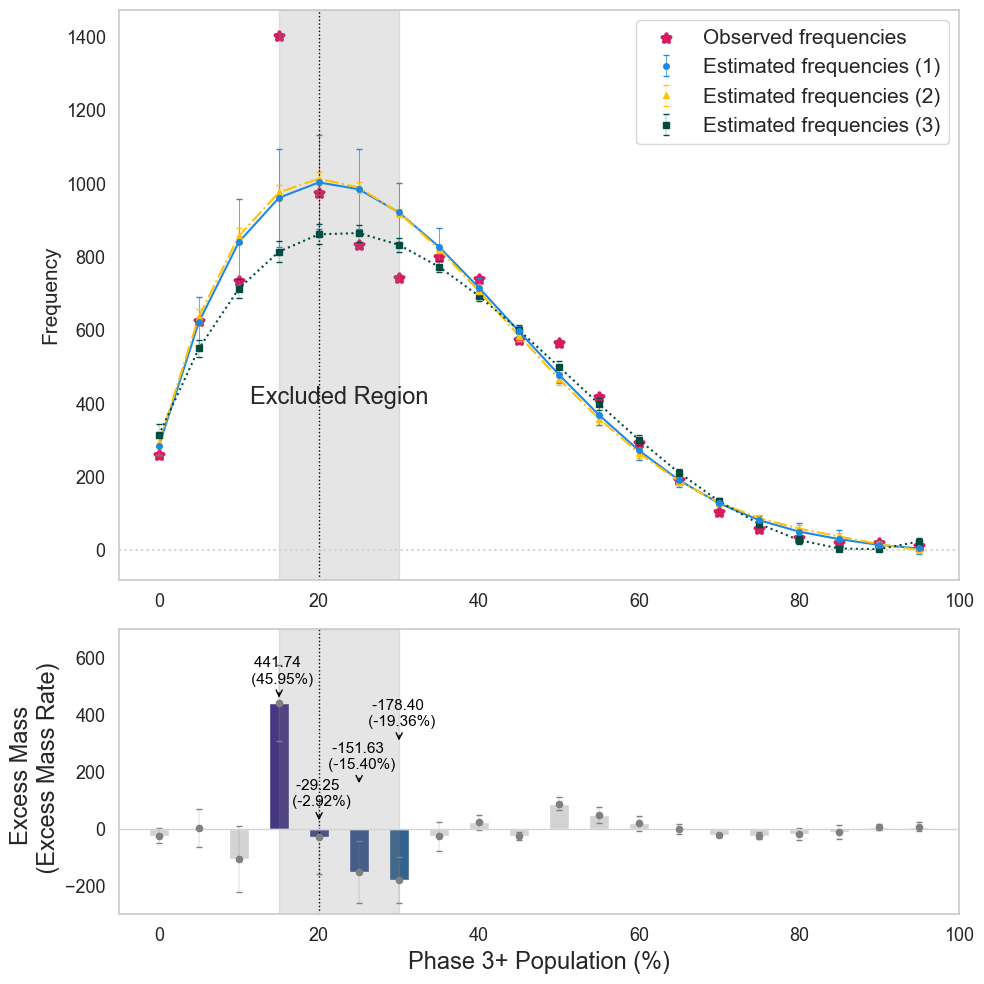

In [23]:
# Create a DataFrame directly from a dictionary
agg_df = pd.DataFrame({
    'bins': bin_midpoints - 0.025,
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_devs': std_devs1
})

agg_df['excess_mass'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])
agg_df['excess_mass_perc'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])/agg_df['mean_coefficients']


# Create subplots
fig, axs = plt.subplots(2,1, figsize = (10,10), gridspec_kw={'height_ratios': [2, 1]})
#fig.subplots_adjust(wspace=0.5) 

# Plot on the first subplot
handle0 = axs[0].scatter(bin_midpoints_orig-0.025, binned_data_orig, label="Binned Data", color='#D81B60', marker='*', linewidth=3)

# Plot on the second subplot

# First, store each errorbar call in a variable to create custom handles
handle3 = axs[0].errorbar(bin_midpoints-0.025, mean_coefficients3, yerr=std_devs3*2, fmt='s', markersize=4, 
                color='#004D40', ecolor='#004D40', elinewidth=0.2, capsize=2)
handle2 = axs[0].errorbar(bin_midpoints-0.025, mean_coefficients2, yerr=std_devs2*2, fmt='^', markersize=4,
                color='#FFC107', ecolor='#FFC107', elinewidth=0.2, capsize=2)
handle1 = axs[0].errorbar(bin_midpoints-0.025, mean_coefficients1, yerr=std_devs1*2, fmt='o', markersize=4,
                color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2)

# Now create the legend explicitly with the desired order
axs[0].legend([handle0, handle1, handle2, handle3], 
              [f'Observed frequencies', 
                f'Estimated frequencies (1)', 
               f'Estimated frequencies (2)', 
               f'Estimated frequencies (3)'
              ], loc="upper right", ncol=1, fontsize=15)

axs[0].plot(bin_midpoints-0.025, mean_coefficients1, color='#1E88E5',)
axs[0].plot(bin_midpoints-0.025, mean_coefficients2, color='#FFC107', linestyle = '-.')
axs[0].plot(bin_midpoints-0.025, mean_coefficients3, color='#004D40', linestyle = ':')
axs[0].axvline(x=0.20, color='black', alpha=1, linestyle=':', linewidth = 1)
axs[0].axhline(y=0.0, color='lightgray', linestyle = ':')


# Adjust x-ticks if needed (commented out as there's no clear definition for `locations`)
axs[0].axvspan(0.15, 0.30, color='gray', alpha=0.2)
locations = np.arange(0, 1.2, 0.2) 
axs[0].set_xticks(locations)
axs[0].set_xticklabels(np.arange(0, 120, 20))
axs[0].set_xlim([-0.05, 1.0])
axs[0].annotate(f"Excluded Region", (0.225, 400), ha = 'center', fontsize = 17)

##################################################################3
x_range = [0.15, 0.20, 0.25, 0.30]
x_beg = 4
x_end = 8

########### AXS1

# Generate colors based on condition
colors = ['viridis_r' if x in x_range else 'gray' for x in agg_df['bins']]

# Ensure the 'bins' variable is categorical for better control over the barplot
agg_df['bins'] = pd.Categorical(agg_df['bins'], categories=np.sort(agg_df['bins'].unique()), ordered=True)

# Create a normalizer object which will map the data values (mean_coefficients1) to the range [0,1] for color mapping
actual_colors = [to_hex(viridis(np.linspace(0, 1, len(colors))[i])) if color == 'viridis_r' else 'lightgray' for i, color in enumerate(colors)]

# Bar plot
axs[1].bar(agg_df['bins'], agg_df['excess_mass'], width = 0.025, color = actual_colors)
axs[1].errorbar(agg_df['bins'], agg_df['excess_mass'], yerr=agg_df['std_devs']*2, 
                fmt='o', color='gray', elinewidth=0.2, capsize=2, markersize = 4.5)

axs[1].axvline(x= 0.2, color = 'black', linestyle = ':', linewidth = 1)
axs[1].axhline(y= 0, color = 'lightgray', linewidth = 1)

np.random.seed(20)

agg_df['y_loc'] = [0,0,0,450, 20, 150, 300, 0,0,0,0,0,0,0,0,0,0,0, 0,0 ]
agg_df['x_loc'] = [0,0,0,0.15, 0.20, 0.225, 0.335, 0,0,0,0,0,0,0,0,0,0,0, 0,0 ]

for p, bin_val, perc, x, y in zip(axs[1].patches, agg_df['bins'], agg_df['excess_mass_perc'], agg_df['x_loc'], agg_df['y_loc']):
    # Check if the current bar is in the special range
    if bin_val in x_range:
        # Jitter: random small adjustments in the x position
        jitter_w = np.random.uniform(-1, 1) * 0.5 * p.get_width()  # Jitter calculation
        jitter_h = np.random.uniform(-1, 1) * 0.5 * p.get_height()  # Jitter calculation
        # Annotate with an arrow
        axs[1].annotate(
            f"{p.get_height():.2f} \n ({perc*100:.2f}%)",  # Text
            xy=(p.get_x() + p.get_width() / 2, y),  # Point to annotate
            xytext=(0.5, 10),  # Position of text relative to point
            textcoords="offset points",
            ha='center',
            va='bottom',
            color='black',
            fontsize=11,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))  # Arrow style

axs[1].set_xlabel('Phase 3+ Population (%)', fontsize=17)
axs[1].set_ylabel('Excess Mass \n (Excess Mass Rate)', fontsize = 17)

# Adjust x-ticks if needed (commented out as there's no clear definition for `locations`)
axs[1].axvspan(0.15, 0.30, color='gray', alpha=0.2)
locations = np.arange(0, 1.2, 0.2) 
axs[1].set_xticks(locations)
axs[1].set_xticklabels(np.arange(0, 120, 20))
axs[0].tick_params(axis='y', labelsize=13) 
axs[1].tick_params(axis='y', labelsize=13)
axs[0].tick_params(axis='x', labelsize=13)
axs[1].tick_params(axis='x', labelsize=13)
axs[0].set_ylabel('Frequency', fontsize=15)
axs[1].set_ylim([-300, 700])
axs[1].set_xlim([-0.05, 1.0])
axs[0].grid(False)
axs[1].grid(False)
plt.tight_layout()
plt.show()



# Figure A2. Differences between observed and estimated frequencies of IPC assessments defined by the proportion of population in phase 3+ by 5% bin

,bins,binned_data_orig,mean_coefficients,excess_mass,excess_mass_perc,t-stat,p_val
0,0.00,260,283.812837,-23.812837,-8.390331,-1.893,0.061
1,0.05,624,622.143946,1.856054,0.298332,0.055,0.956
2,0.10,735,840.784825,-105.784825,-12.581676,-1.822,0.071
3,0.15,1403,961.258105,441.741895,45.954556,6.619,0.000
4,0.20,974,1003.253249,-29.253249,-2.915839,-0.456,0.649
5,0.25,833,984.626548,-151.626548,-15.399397,-2.793,0.006
6,0.30,743,921.401130,-178.401130,-19.361940,-4.405,0.000
7,0.35,801,827.766952,-26.766952,-3.233634,-1.040,0.301
8,0.40,739,716.080803,22.919197,3.200644,1.787,0.077
9,0.45,572,596.866303,-24.866303,-4.166143,-3.319,0.001


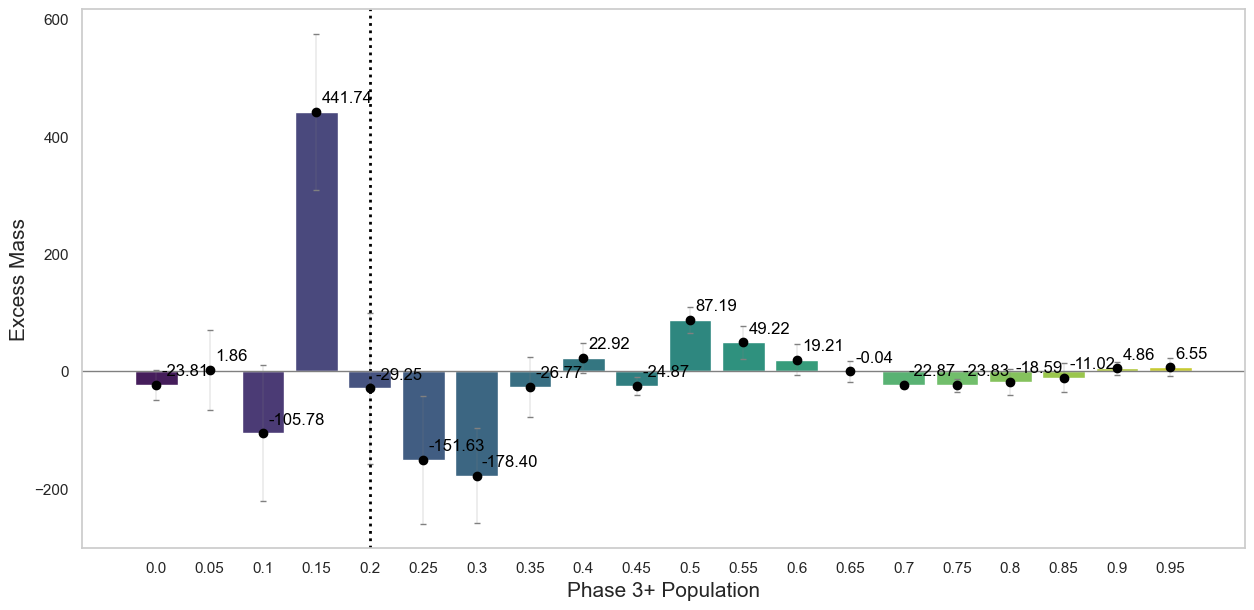

In [24]:
# Create a DataFrame directly from a dictionary
agg_df = pd.DataFrame({
    'bins': bin_midpoints - 0.025,
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_errors': std_devs1
})

agg_df['excess_mass'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])
agg_df['excess_mass_perc'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])/agg_df['mean_coefficients']*100
agg_df['t-stat'] = (agg_df['excess_mass']/agg_df['std_errors']).round(3)
agg_df['p_val'] =[(2 * (1 - stats.t.cdf(np.abs(t), df=100-1))).round(3) for t in agg_df['t-stat']]
agg_df['bins'] = agg_df['bins'].round(2)

fig, ax = plt.subplots(1, figsize =(15,7))

# Ploat barplots with 'Standard Errors'
ax = sns.barplot(data = agg_df, x= 'bins',y = 'excess_mass',  palette='viridis',)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

ax.errorbar(x=x_coords, y=y_coords, yerr = std_devs1 * 2, 
            fmt='o', color='black', ecolor='gray', elinewidth=0.2, capsize=2)

ax.axvline(x= 4, color = 'black', linestyle = ':', linewidth = 2)
ax.axhline(y= 0, color = 'gray', linewidth = 1)

ax.set_xlabel('Phase 3+ Population', fontsize = 15)
ax.set_ylabel('Excess Mass', fontsize = 15)
ax.grid(False)
# Annotate each bar with the actual number
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 1.6, p.get_height()), 
                ha='left', va='center', color = 'black',
                xytext=(0, 10), fontsize = 12,
                textcoords='offset points')
    
agg_df[['bins','binned_data_orig','mean_coefficients','excess_mass','excess_mass_perc','t-stat', 'p_val']]



# Figure A3. Bunching analysis results: analyzing the impact of excluded bins  

Excluded points:  0.15
Filtered_midpoints:  [0.   0.05 0.1  0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.2
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.25
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.3
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.25 0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Poly Degree:  4


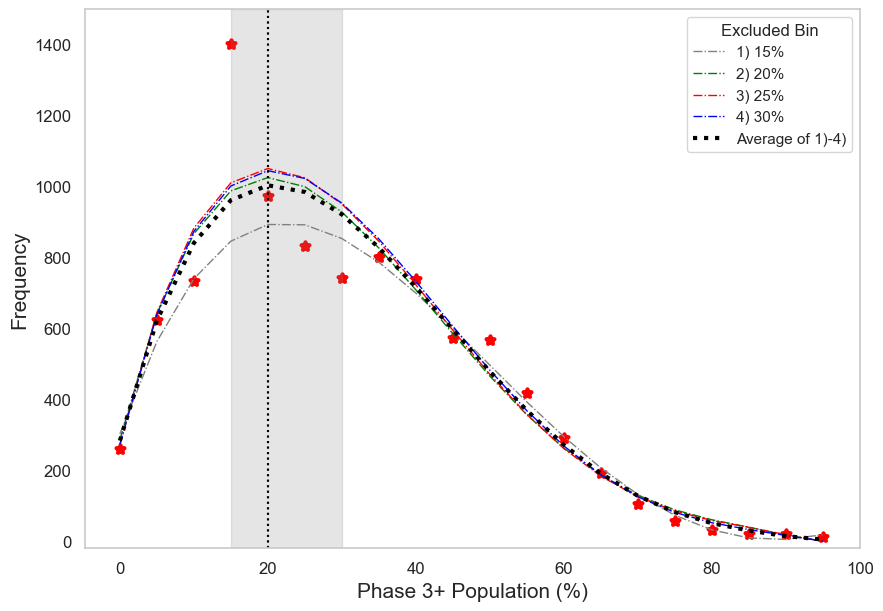

In [25]:
# Set Data and Key Parameters
np.random.seed(123)  # Set seed for reproducibility
num_simulations = 500  # Number of simulations to run

# Replacing below parameter will recreate Figure A1
###################################################################################
poly_degree = 4  # 3, 5, 6, 7
###################################################################################

var = 'phase3plus_perc'  # Column name to be analyzed

# Prepare the Data
sub_df = rounded_df.copy()  # Copy the original dataframe for analysis
data = sub_df[f'{var}']  # Extract the data from the specified column
data_size = len(data)

# Step 1: Original Density Setup
zstar = 0.20  # Exclusion threshold value for bin filtering in simulations
binwidth = 0.05  # Width of each bin for histogramming data

# Create bins and bin midpoints for histogram calculations
bins_orig = np.arange(0, 1 + binwidth, binwidth)  # Define the bin edges for original data
binned_data_orig, _ = np.histogram(data.round(2), bins_orig.round(2))  # Histogram the original data
bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2  # Calculate midpoints of the original bins

# Create bins and midpoints for simulation purposes
bins = np.arange(0, 1 + binwidth, binwidth)  # Define bins for the simulations
bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)  # Calculate midpoints of the bins

############## Simulation 1 ##################

# Initialize arrays to store polynomial coefficients for each exclusion
coefficients_matrix_125 = np.zeros((num_simulations, 20))  # 10% excluded
coefficients_matrix_175 = np.zeros((num_simulations, 20))  # 15% excluded
coefficients_matrix_225 = np.zeros((num_simulations, 20))  # 20% excluded
coefficients_matrix_275 = np.zeros((num_simulations, 20))  # 25% excluded
coefficients_matrix_325 = np.zeros((num_simulations, 20))  # 30% excluded

# Define the bin_midpoints to exclude in each set of simulations
exclude_points = [0.175, 0.225, 0.275, 0.325]  # Exclude these midpoints one at a time

# Loop through the exclusion points and perform simulations
for k in range(len(exclude_points)):
    print('Excluded points: ', exclude_points[k] - 0.025)
    
    for j in range(num_simulations):
        # Simulate a subset of data
        simulated_data = data.sample(len(data), replace = True)
        
        # Bin the simulated data
        binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))
        
        # Filter out the bin corresponding to the excluded point
        filtered_midpoints = bin_midpoints[bin_midpoints != exclude_points[k]]
        filtered_counts = binned_data[bin_midpoints != exclude_points[k]]
        
        # Polynomial fitting on the filtered data
        coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
        poly_func = np.poly1d(coefficients)  # Create polynomial function from coefficients
        
        # Generate points along the polynomial curve
        x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
        y_poly = poly_func(x_poly)
        
        # Set negative values to 0 for valid probability density
        y_poly = np.where(y_poly < 0, 0, y_poly)
        
        # Store the polynomial values in the corresponding matrix
        if k == 0:
            coefficients_matrix_175[j, :] = y_poly
        elif k == 1:
            coefficients_matrix_225[j, :] = y_poly
        elif k == 2:
            coefficients_matrix_275[j, :] = y_poly
        else:
            coefficients_matrix_325[j, :] = y_poly

    print('Filtered_midpoints: ', filtered_midpoints - 0.025)

# Combine coefficient matrices from all exclusions into a single 3D array
all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                     coefficients_matrix_275, coefficients_matrix_325))
#print(all_coefficients_matrix.shape)

# Compute mean of all coefficients across simulations
mean_coefficients1 = np.mean(all_coefficients_matrix, axis=0)

# Calculate standard devs for the coefficients
std_devs1 = np.std(all_coefficients_matrix, axis=0, ddof=1)


# Construct a 95% confidence interval
print('Poly Degree: ', poly_degree)

plt.figure(figsize = (10,7))

# plot 1 - Original Counts
plt.scatter(bin_midpoints_orig - 0.025, binned_data_orig, label="Binned Data", color='red', marker = '*', linewidth = 3)

for i, c in zip([coefficients_matrix_175, coefficients_matrix_225, coefficients_matrix_275,  coefficients_matrix_325,
                 [coefficients_matrix_175, coefficients_matrix_225, coefficients_matrix_275, coefficients_matrix_325]], 
                 ['gray', 'green', 'red', 'blue', 'black', ]):
    all_coefficients_matrix = np.vstack((i)) 
    mean_coefficient1 = np.mean(all_coefficients_matrix, axis=0)
    std_error1 = np.std(all_coefficients_matrix, axis=0, ddof=1)
    
    #plt.fill_between(bin_midpoints-0.025, mean_coefficient1 - 1.96 * std_error1, mean_coefficient1 + 1.96 * std_error1, color=c, alpha=0.2)
    if i[0].shape[0] > 20:
        plt.plot(bin_midpoints-0.025, mean_coefficient1, color=c, alpha = 1, linewidth = 3, linestyle = ':')
        #print(i)
    else:
        plt.plot(bin_midpoints-0.025, mean_coefficient1, color=c, alpha = 1, linewidth = 1, linestyle = '-.')

        

# plot 3 - Coefficients Line plot

plt.axvline(x=0.20, color='black', alpha=0.5, linestyle = ':')
plt.ylim(-20, 1500)

plt.axvspan(0.15, 0.30, color='gray', alpha=0.2)

locations, labels = plt.xticks()
plt.xticks(ticks=locations[:-1]+0.2, labels=np.arange(0, 120, 20))

plt.gca().tick_params(axis='x', labelsize=12) 
plt.gca().tick_params(axis='y', labelsize=12) 

plt.legend(title = 'Excluded Bin', labels = ['1) 15%','2) 20%','3) 25%','4) 30%', 'Average of 1)-4)'])    
#plt.ylim(0, 1500)
plt.axvline(x = 0.2, color = 'black', linestyle = ':')

plt.xlabel('Phase 3+ Population (%)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.grid(False)
#plt.axhline(y = 0.0, color = 'gray')
#plt.legend(['simulation w/o 0.15','simulation w/o 0.20','simulation w/o 0.25', 'Average of simulated results 1-3', 'actual count'])    

# Figure A4. Histograms of rounded and unrounded IPC assessments defined by the proportion of population in phase 3+ (%)

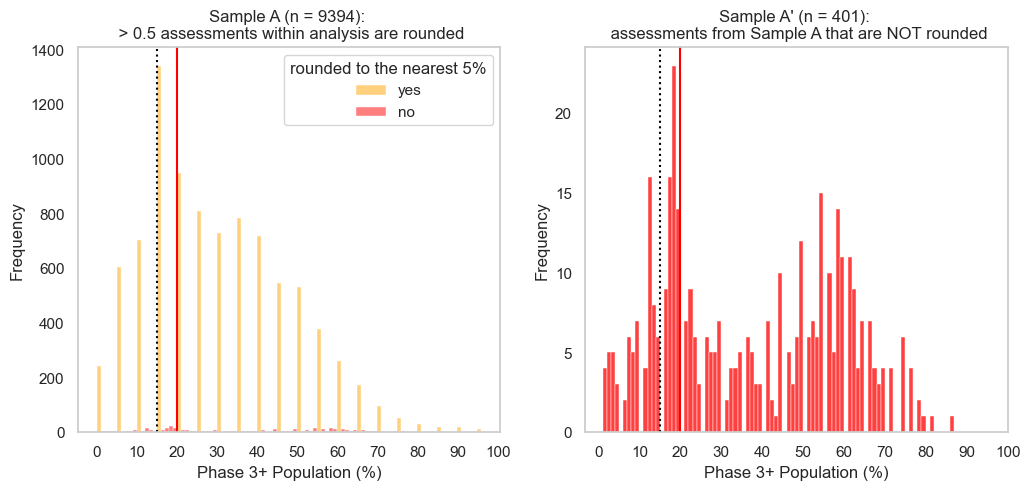

In [26]:
fig, ax = plt.subplots(1,2, figsize =  (12,5))

var = 'phase3plus_perc'

rounded_df['rounded to the nearest 5%'] = np.where(rounded_df[var].isin(roundnumber), 'yes','no')

sns.histplot(data=rounded_df, x=var, binwidth = 0.00999, ax = ax[0], hue = 'rounded to the nearest 5%', kde = False, 
             palette ={'yes':'orange','no':'red'})

ax[0].axvline(x= 0.2, color  = 'red')
ax[0].axvline(x= 0.15, color  = 'black', linestyle = ':')
ax[0].set_xlabel('Phase 3+ Population (%)', fontsize = 12)
ax[0].set_ylabel('Frequency', fontsize = 12)
ax[0].set_title(f'Sample A (n = {len(rounded_df)}): \n > 0.5 assessments within analysis are rounded')

locations = np.arange(0, 1.1, 0.1)
ax[0].set_xticks(locations)
ax[0].set_xticklabels(np.arange(0, 110, 10))

sns.histplot(rounded_df[~rounded_df[var].isin(np.arange(0,1,0.05).round(2))][var], binwidth = 0.00999, ax = ax[1], kde = False,  
             color = 'red')
ax[1].axvline(x= 0.2, color  = 'red')
ax[1].axvline(x= 0.15, color  = 'black', linestyle = ':')
ax[1].set_xlabel('Phase 3+ Population (%)', fontsize = 12)
ax[1].set_ylabel('Frequency', fontsize = 12)
ax[1].set_title(f"Sample A' (n = {len(rounded_df[~rounded_df[var].isin(np.arange(0,1,0.05).round(2))][var])}): \n assessments from Sample A that are NOT rounded")


locations = np.arange(0, 1.1, 0.1)
ax[1].set_xticks(locations)
ax[1].set_xticklabels(np.arange(0, 110, 10))

ax[0].grid(False)
ax[1].grid(False)


# Figure A5. Year x Round specific observed and estimated distributions of IPC assessments defined by the proportion of population in phase 3+ for Afghanistan

[('Afghanistan', '2019-08'), ('Afghanistan', '2020-04'), ('Afghanistan', '2020-08'), ('Afghanistan', '2021-03'), ('Afghanistan', '2021-09'), ('Afghanistan', '2022-03'), ('Afghanistan', '2022-09'), ('Afghanistan', '2023-04'), ('Afghanistan', '2023-10')] 9
(Afghanistan, 2019-08)    34
Name: index, dtype: int64
('Afghanistan', '2019-08') 34
(2000, 20)
(Afghanistan, 2020-04)    45
Name: index, dtype: int64
('Afghanistan', '2020-04') 45
(2000, 20)
(Afghanistan, 2020-08)    45
Name: index, dtype: int64
('Afghanistan', '2020-08') 45
(2000, 20)
(Afghanistan, 2021-03)    45
Name: index, dtype: int64
('Afghanistan', '2021-03') 45
(2000, 20)
(Afghanistan, 2021-09)    45
Name: index, dtype: int64
('Afghanistan', '2021-09') 45
(2000, 20)
(Afghanistan, 2022-03)    45
Name: index, dtype: int64
('Afghanistan', '2022-03') 45
(2000, 20)
(Afghanistan, 2022-09)    45
Name: index, dtype: int64
('Afghanistan', '2022-09') 45
(2000, 20)
(Afghanistan, 2023-04)    45
Name: index, dtype: int64
('Afghanistan', '2

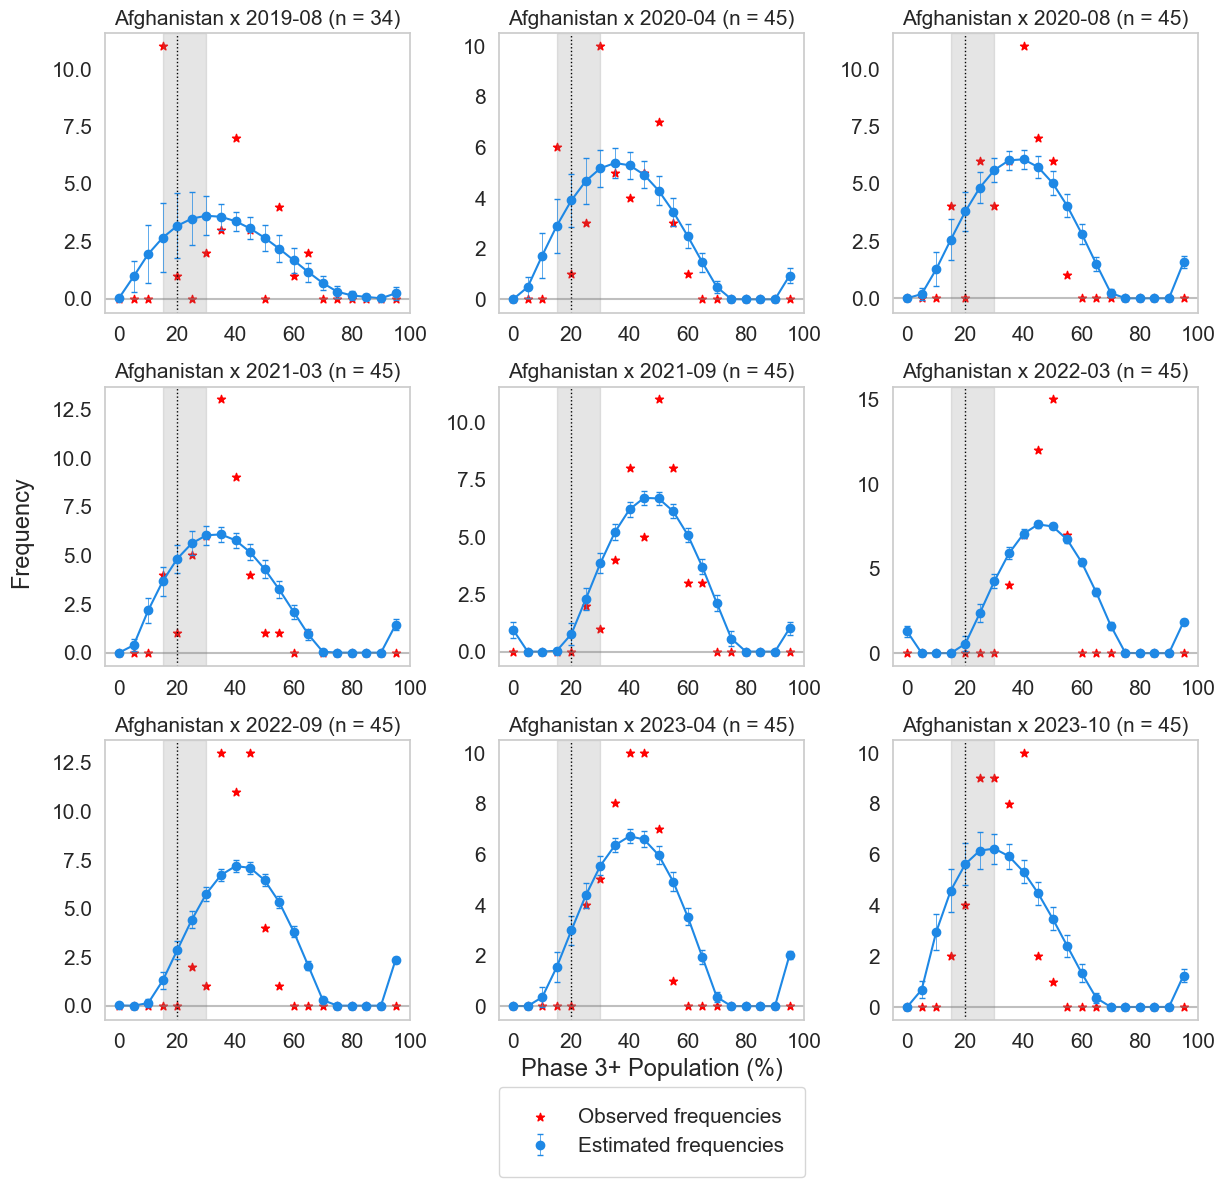

In [27]:
var = 'phase3plus_perc'
countries = sorted(rounded_df[(rounded_df['country_name'] == 'Afghanistan')]['index'].unique())[2:]
print(countries, len(countries))
num_simulations = 500  # Number of simulations
poly_degree = 4  # Degree of polynomial
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

agg = []

no_kenya =['KAWANGWARE',
 'MUKURU',
 'GITHURAI',
 'KANGEMI',
 'KAYOLE',
 'BANGLADESH',
 'DANDORA',
 'OBUNGA',
 'KONDELE',
 'KIBRA',
 'MWEMBE TAYARI',
 'MATHARE']


for i, c in enumerate(sorted(countries)):
    
    sub_df = rounded_df[(rounded_df['index'] == c) & ~(rounded_df['Area'].isin(no_kenya)) & ~(rounded_df['index'].isin(exclude_index))]
    print(sub_df['index'].value_counts().sort_index())
    data = sub_df[f'{var}']
    
    print(c, len(data))
    
    # Parameters for the Monte Carlo simulation
    np.random.seed(1234)
    data_size = len(data)  # Size of each simulated dataset
        
    binwidth = 0.05
    bins = np.arange(0, 1 + binwidth, binwidth)
    bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)
    
    # Initialize arrays to store coefficients from each simulation set
    coefficients_matrix_125 = np.zeros((num_simulations, 20))
    coefficients_matrix_175 = np.zeros((num_simulations, 20))
    coefficients_matrix_225 = np.zeros((num_simulations, 20))
    coefficients_matrix_275 = np.zeros((num_simulations, 20))
    coefficients_matrix_325 = np.zeros((num_simulations, 20))
    
    # Define the bin_midpoints to exclude in each set of simulations
    exclude_points = [0.175, 0.225, 0.275, 0.325]
    
    # Run simulations for each exclusion
    for k in range(len(exclude_points)):
        
        for j in range(num_simulations):
        
            simulated_data = data.sample(data_size, replace = True)
            binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))

            # Filter midpoints excluding one at a time
            filtered_midpoints = bin_midpoints[bin_midpoints != exclude_points[k]]
            filtered_counts = binned_data[bin_midpoints != exclude_points[k]]

            # Polynomial fitting
            coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
            poly_func = np.poly1d(coefficients)
            x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
            y_poly = poly_func(x_poly)
            
            # Replace negative values with 0
            y_poly = np.where(y_poly < 0, 0, y_poly)

            # Store coefficients in the corresponding matrix
            if k == 0:
                coefficients_matrix_175[j, :] = y_poly
            elif k == 1:
                coefficients_matrix_225[j, :] = y_poly
            elif k == 2:
                coefficients_matrix_275[j, :] = y_poly
            else:
                coefficients_matrix_325[j, :] = y_poly


    # Concatenate the matrices into a single 3D array
    all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                         coefficients_matrix_275, coefficients_matrix_325))
    print(all_coefficients_matrix.shape)
    
    # Calculate standard errors for each coefficient
    mean_coefficients = np.mean(all_coefficients_matrix, axis=0) 
    std_errors = np.std(all_coefficients_matrix, axis=0, ddof = 1)
    
    # Initialize an array to store coefficients from each simulation
    coefficients_matrix = np.zeros((num_simulations, 20))

    # Create subplots
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # Step 1: Original Density
    zstar = 0.20
    binwidth = 0.05
    bins_orig = np.arange(0, 1 + binwidth, binwidth)
    binned_data_orig, _ = np.histogram(data.round(2), bins_orig.round(2))
    bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2

    
    # plot 1 - Original Counts
    ax.scatter(bin_midpoints_orig - 0.025, binned_data_orig, label="Binned Data", color='red', marker = '*')

    # plot 2 - Simulated Counts with standard errors
    
    ax.errorbar(bin_midpoints - 0.025, mean_coefficients, yerr=std_errors,
                fmt='o', color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2)
    

    ax.set_title(f'{c[0]} x {c[1]} (n = {len(data)})', fontsize = 15)
    
    if (row == 2) & (col == 1):
        ax.legend([f'Observed frequencies', 
               f'Estimated frequencies', ], 
              bbox_to_anchor = (0.5, -0.4), borderpad = 1.0, loc="center", ncol=1, fontsize = 15)
        ax.set_xlabel('Phase 3+ Population (%)', fontsize = 17)
    
    else:
        pass
    
    # plot 3 - Coefficients Line plot
    ax.plot(bin_midpoints - 0.025, mean_coefficients, color='#1E88E5')
    
    ax.axvline(x=0.20, color='black', alpha=1, linestyle=':', linewidth = 1)
    #axs[0].axhline(y=0.20, color='gray', alpha=0.5, linestyle='-')

    ax.axvspan(0.15, 0.30, color='gray', alpha=0.2)
    ax.axhline(y=0.0, color='gray', alpha=0.5)
    
    ax.set_xticks(np.arange(0, 1.05, 0.2))  # Set ticks from 0 to 1 by 0.2
    ax.set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])  # Optional: Format labels to 2 decimal places
    
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # Create a DataFrame directly from a dictionary
    agg_df = pd.DataFrame({
        'bins': bin_midpoints - 0.025,
        'binned_data_orig': binned_data_orig,
        'mean_coefficients': mean_coefficients
    })

    agg_df['excess_mass'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])/agg_df['mean_coefficients']
    agg.append(agg_df)
    
 
    ## Define the bins for the histogram
    bins = np.arange(sub_df[f'{var}'].min(), sub_df[f'{var}'].max() + 0.04999, 0.04999)

    ## Define colors for each 'overall_phase'
    colors = {1: 'aqua', 2: 'yellow', 3: 'orange', 4: 'red', 5: 'darkred'}
    ax.grid(False)
    ## Plot histogram for each 'overall_phase'

plt.tight_layout()
fig.text(-0.01, 0.55, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=17)

plt.show()


# Figure A6. Observed and estimated distributions of IPC assessments defined by the proportion of population in phase 3+by available group of FSIs 

(2000, 20)
(2000, 20)
(2000, 20)
(2000, 20)


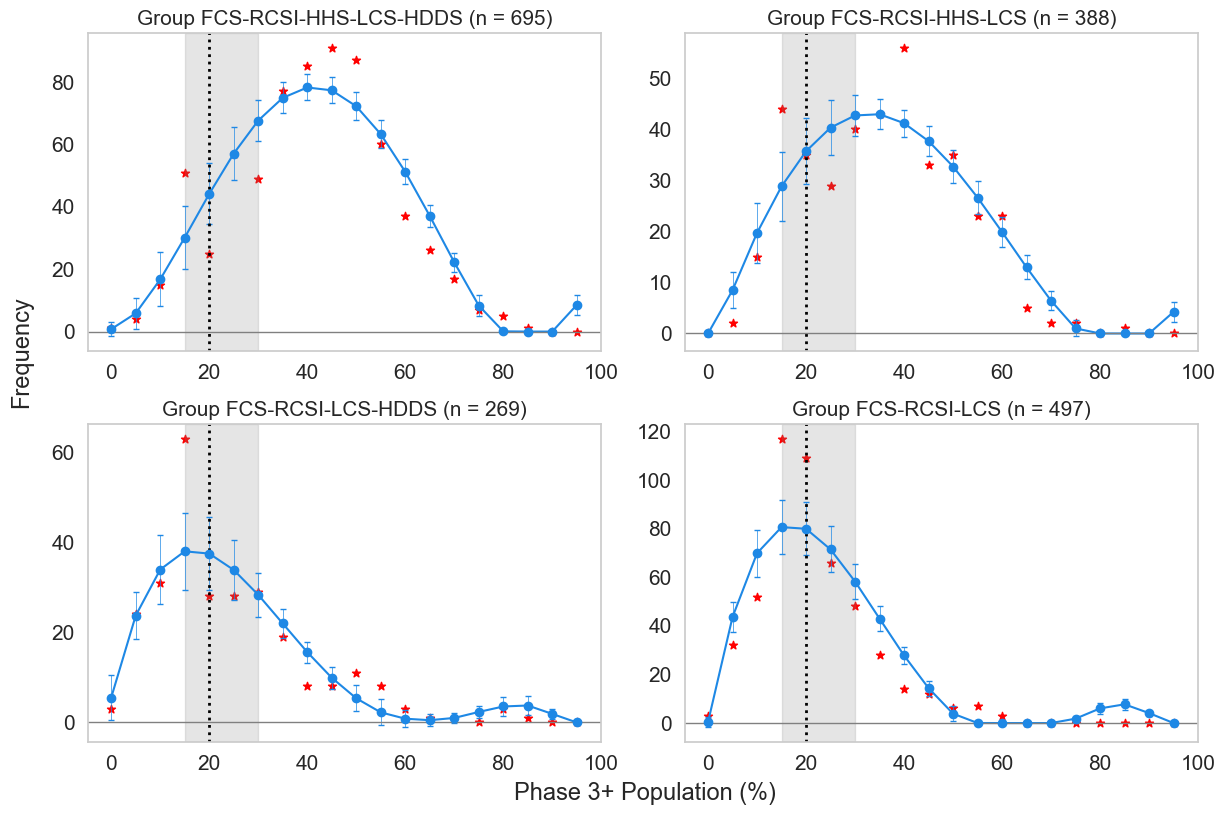

In [28]:
sub_df = ipc_df_sub.copy()
# Assuming 'data' is your DataFrame
groups = sub_df['FSI_combination'].unique()

# Set up parameters
np.random.seed(1234)
num_simulations = 500  # Number of simulations per group
poly_degree = 4  # Degree of polynomial
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Create subplots
fig, axes = plt.subplots(len(groups)//2, 2, figsize=(12, len(groups)//2 * 4))
axes = axes.flatten()  # Flatten the axes array

aggre_df = []

for i, group in enumerate(groups):
    # Filter data for the current group
    group_data = sub_df[sub_df['FSI_combination'] == group]['phase3_plus']
    
    ax = axes[i]
    
    # Step 1: Original Density
    zstar = 0.20
    binwidth = 0.05
    bins_orig = np.arange(0, 1 + binwidth, binwidth)
    binned_data_orig, _ = np.histogram(group_data.round(2), bins_orig.round(2))
    bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2
    data_size = len(group_data)
    # Initialize array to store coefficients for each simulation
    
    coefficients_matrix_175 = np.zeros((num_simulations, 20))
    coefficients_matrix_225 = np.zeros((num_simulations, 20))
    coefficients_matrix_275 = np.zeros((num_simulations, 20))
    coefficients_matrix_325 = np.zeros((num_simulations, 20))
    
    exclude_points = [0.175, 0.225, 0.275, 0.325]
    
    # Run simulations for each exclusion
    for k in range(len(exclude_points)):
        for j in range(num_simulations):
            simulated_data = group_data.sample(data_size, replace = 5)
            #print(len(simulated_data))
            bins = np.arange(0, 1 + binwidth, binwidth)
            binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))
            bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)
            # Filter midpoints excluding one at a time
            filtered_midpoints = bin_midpoints[bin_midpoints != round(exclude_points[k],3)]
            filtered_counts = binned_data[bin_midpoints != round(exclude_points[k],3)]

            # Polynomial fitting
            coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
            poly_func = np.poly1d(coefficients)
            
            x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
            y_poly = poly_func(x_poly)
            
            # Replace negative values with 0
            y_poly = np.where(y_poly < 0, 0, y_poly)

            # Store coefficients in the corresponding matrix
            if k == 0:
                coefficients_matrix_175[j, :] = y_poly   
            elif k == 1:
                coefficients_matrix_225[j, :] = y_poly
            elif k == 2:
                coefficients_matrix_275[j, :] = y_poly
            else:
                coefficients_matrix_325[j, :] = y_poly
        #print('filtered_midpoints', filtered_midpoints+0.025,'\n', )
    
    # Concatenate the matrices into a single 3D array
    all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                         coefficients_matrix_275, coefficients_matrix_325))
    print(all_coefficients_matrix.shape)
    # Calculate mean coefficients and standard errors
    mean_coefficients = np.mean(all_coefficients_matrix, axis=0)
    std_errors = np.std(all_coefficients_matrix, axis=0, ddof=1)
    
        # Create a DataFrame directly from a dictionary
    agg_df = pd.DataFrame({
        'bins': bin_midpoints - 0.025,
        'binned_data_orig': binned_data_orig,
        'mean_coefficients': mean_coefficients,
        'std_errors1': std_errors
    })
    
    aggre_df.append(agg_df)
    # plot 1 - Original Counts
    #ax.scatter(bin_midpoints - 0.025, binned_data_orig, label="Binned Data", color='red', marker = '*')
    #sns.histplot(group_data, ax = ax)
    
    # Plotting
    ax.scatter(bin_midpoints_orig - 0.025, binned_data_orig, label="Binned Data", color='red', marker = '*')
    
    ax.errorbar(bin_midpoints - 0.025, mean_coefficients, yerr=std_errors*1.96, 
                fmt='o', color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2)
    ax.plot(bin_midpoints - 0.025, mean_coefficients, color='#1E88E5')
    
    ax.axvspan(0.15, 0.30, color='gray', alpha=0.2)
    
    #ax.set_xlabel('Phase 3+ Population (%)', fontsize = 15)
    #ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_title(f'Group {group} (n = {len(group_data)})', fontsize = 15)
    ax.set_xticks(np.arange(0, 1.05, 0.2))  # Set ticks from 0 to 1 by 0.2
    ax.set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])  # Optional: Format labels to 2 decimal places
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    
    ax.axvline(x = 0.2, color = 'black', linewidth = 2, linestyle = ':')
    ax.axhline(y = 0, color = 'gray',linewidth = 1 )
    ax.grid(False)
    
    
plt.tight_layout()
fig.text( 0.4, -0.01, 'Phase 3+ Population (%)', fontsize = 17)
fig.text(-0.01, 0.55, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=17)

plt.show()


# Figure A7. Year-specific distribution of IPC assessments defined by the proportion of population in phase 3+ (%)

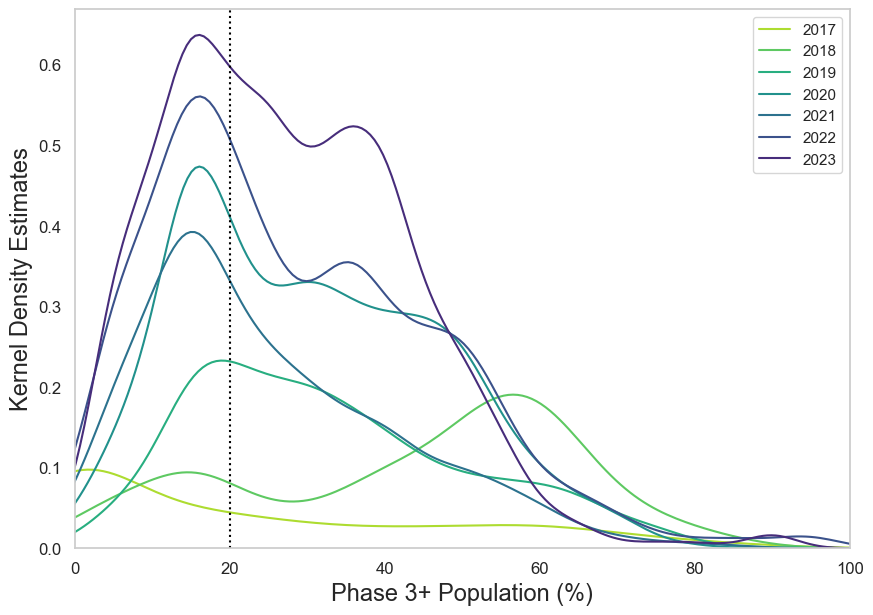

In [29]:
plt.figure(figsize = (10,7))

ax = sns.kdeplot(data = rounded_df[rounded_df['year'].isin(['2017', '2018','2019', '2020', '2021', '2022', '2023'])], 
                 x = 'phase3plus_perc',  hue = 'year', bw_adjust = 1, palette = 'viridis')
ax.axvline( x= 0.2, color = 'black', linestyle = ':')

ax.set_xlabel('3+ population')
# Formatting tick labels
ax.set_xticks(np.arange(0, 1.05, 0.2))  # Set ticks from 0 to 1 by 0.2
ax.set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)]) 
ax.set_xlabel('Phase 3+ Population (%)', fontsize = 17)
ax.set_ylabel('Kernel Density Estimates', fontsize = 17)
ax.legend(['2017', '2018','2019', '2020', '2021', '2022', '2023'])
ax.tick_params(axis='x', labelsize=12) 
ax.tick_params(axis='y', labelsize=12) 

ax.set_xlim([0,1])

ax.grid(False)

# Figure A8: Comparisons of cumulative distributions of IPC assessments defined by proportion of population in phase 3+ (Observed vs Counterfactual)

0.4381327046088647 0.5901010267760959
0.43183326734462757 0.5708462343707632
0.25379144813468685 0.37840199238482763
0.2094636457354656 0.3100406565642152


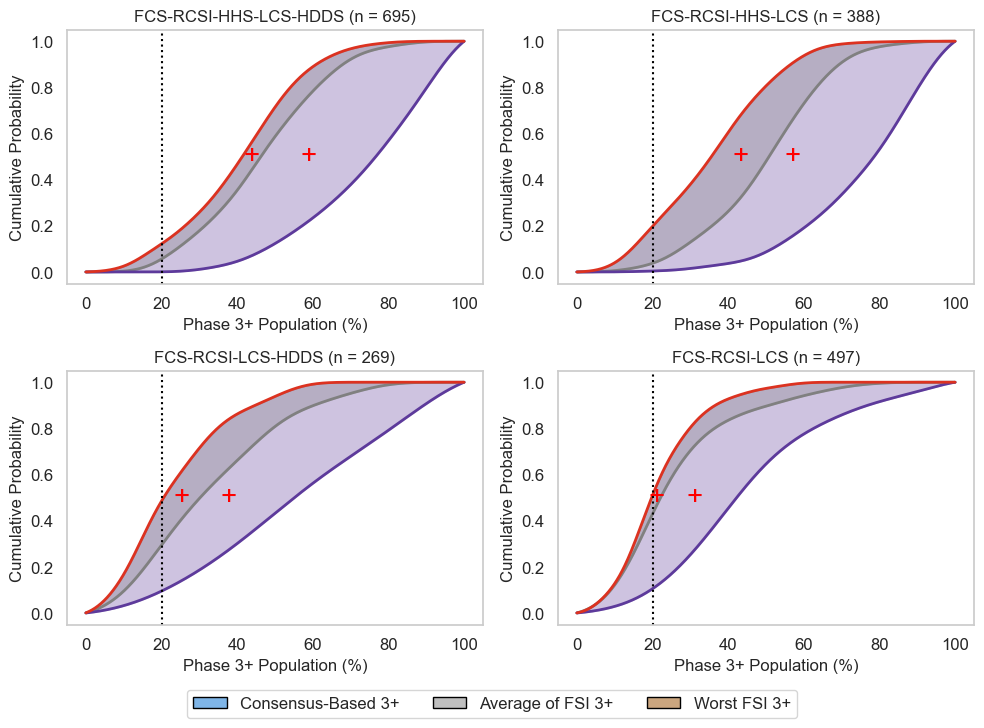

In [30]:
# Assume data is loaded into 'plot_df' and organized by 'FSI_combination'

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

unique_combinations = ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS','FCS-RCSI-LCS']

for i, g in enumerate(unique_combinations):
    row = i // 2
    col = i % 2
    plot_df_org = ipc_df_sub[(ipc_df_sub['FSI_combination'] == g)]
    plot_df = ipc_df_sub[(ipc_df_sub['FSI_combination'] == g)].dropna(subset =['phase3_plus','worst_fsi','average_3plus'])
    
    # Generate a range of values for KDE evaluation
    x = np.linspace(0, 1, 1000)
    
    # Calculate KDE and then the cumulative sum for CDF
    kde_avg = gaussian_kde(plot_df['average_3plus'])
    density_avg = kde_avg(x)
    cdf_avg = np.cumsum(density_avg)
    cdf_avg /= cdf_avg[-1]

    kde_worst = gaussian_kde(plot_df['worst_fsi'])
    density_worst = kde_worst(x)
    cdf_worst = np.cumsum(density_worst)
    cdf_worst /= cdf_worst[-1]

    kde_3plus = gaussian_kde(plot_df['phase3_plus'])
    density_3plus = kde_3plus(x)
    cdf_3plus = np.cumsum(density_3plus)
    cdf_3plus /= cdf_3plus[-1]

    # Plot the CDFs
    ax[row, col].plot(x, cdf_avg, label='Average FSI 3+', color='gray', linewidth = 2)
    ax[row, col].plot(x, cdf_worst, label='Worst FSI 3+', color='#5D3A9B', linewidth = 2)
    ax[row, col].plot(x, cdf_3plus, label='Consensus-based 3+', color='#DC3220', linewidth = 2)
    
    # Find the x position where the average CDF intersects y=0.5

    # Interpolate to find the x value for cum_prob_avg at y=0.5
    x_value_avg_at_05 = np.interp(0.5, cdf_avg, x)
    # Interpolate to find the x value for cum_prob_3plus1 at y=0.5
    x_value_3plus_at_05 = np.interp(0.5, cdf_3plus, x)

    # Calculate the average of the two x values
    avg_x_at_05 = (x_value_avg_at_05 + x_value_3plus_at_05) / 2
    
    # Interpolate to find the x value for cum_prob_avg at y=0.5
    x_value_worst_at_05 = np.interp(0.5, cdf_worst, x)
    # Interpolate to find the x value for cum_prob_3plus1 at y=0.5
    x_value_3plus_at_05_1 = np.interp(0.5, cdf_3plus, x)

    # Calculate the average of the two x values
    avg_x_at_05 = (x_value_avg_at_05 + x_value_3plus_at_05) / 2
    avg_x_at_05_1 = (x_value_worst_at_05 + x_value_3plus_at_05_1) / 2
    
    print(avg_x_at_05, avg_x_at_05_1)
    
    # Annotate "+" in the middle of the fill_between area
    ax[row, col].annotate('+', xy=(avg_x_at_05_1, 0.5), fontsize=20, ha='center', va='center', color='red')

    # Annotate "+" in the middle of the fill_between area
    ax[row, col].annotate('+', xy=(avg_x_at_05, 0.5), fontsize=20, ha='center', va='center', color='red')

    
    # Fill between CDFs
    #ax[row, col].fill_between(x, cdf_avg, cdf_3plus, where=(cdf_3plus >= cdf_avg), color='#0C7BDC', alpha=0.5)
    ax[row, col].fill_between(x, cdf_worst, cdf_3plus, where=(cdf_3plus >= cdf_worst), color='#5D3A9B', alpha=0.3)
    ax[row, col].fill_between(x, cdf_avg, cdf_3plus, where=(cdf_3plus >= cdf_avg), color='gray', alpha=0.3)

    ax[row, col].set_title(f"{g} (n = {len(plot_df_org)})", fontsize=12)
    
    #ax[row, col].legend(loc='upper left')
    ax[row, col].set_xlabel('Phase 3+ Population (%)', fontsize = 12)
    ax[row, col].set_ylabel('Cumulative Probability', fontsize = 12)
    
    # Formatting tick labels
    ax[row, col].set_xticks(np.arange(0, 1.05, 0.2))  # Set ticks from 0 to 1 by 0.2
    ax[row, col].set_xticklabels([f'{x*100:.0f}' for x in np.arange(0, 1.05, 0.2)])  # Optional: Format labels to 2 decimal places

    
    # Formatting tick labels
    for label in ax[row, col].get_xticklabels() + ax[row, col].get_yticklabels():
        label.set_fontsize(18)
    
    # Adding a vertical line for reference
    ax[row, col].axvline(x=0.2, color='black',  linestyle = ':')
    #ax[row, col].legend(['Average of FSI 3+','Worst FSI 3+', 'Consensus-Based 3+'], loc='lower right', fontsize=17)
    
    # Remove grid lines
    ax[row, col].grid(False)
    ax[row, col].grid(False)
    
    ax[row, col].tick_params(axis='y', labelsize=12)
    ax[row, col].tick_params(axis='x', labelsize=12)


plt.tight_layout()
fig.legend([handles[0], handles[2], handles[1]], ['Consensus-Based 3+', 'Average of FSI 3+','Worst FSI 3+'], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

plt.show()


# Figure A9. Monte-Carlo simulation results: analyzing the impact of excluding any one FSI on the estimated distribution of IPC assessments defined by the proportion of population in phase 3+ by FSI group

695
695
['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']
(2500, 20)


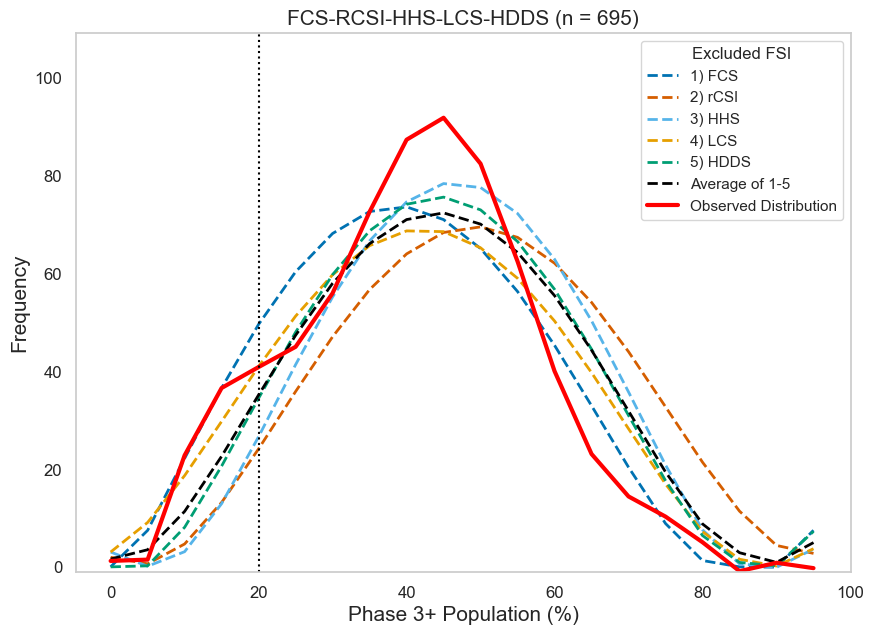

In [31]:
# Replace below parameter to 
########################################################################
group = 'FCS-RCSI-HHS-LCS-HDDS' # 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-LCS',  'FCS-RCSI-LCS-HDDS'   
########################################################################

group_data = ipc_df_sub[(ipc_df_sub['FSI_combination'] == group)]

combi_match = {'FCS-RCSI-HHS-LCS'      : ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up',                ],
             'FCS-RCSI-HHS-LCS-HDDS' : ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'],
             'FCS-RCSI-LCS'          : ['FCS_3plus_up', 'rCSI_3plus_up',                 'lcs_3plus_up',                ],
             'FCS-RCSI-LCS-HDDS'     : ['FCS_3plus_up', 'rCSI_3plus_up',                 'lcs_3plus_up', 'hdds_3plus_up']}

#ax = axes[i]

# Step 1: Original Density
zstar = 0.20
binwidth = 0.05
bins_orig = np.arange(0, 1 + binwidth, binwidth)
binned_data_orig, _ = np.histogram(group_data['phase3_plus_up'].round(2), bins_orig.round(2))
bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2

print(len(group_data))

print(len(group_data))
data_size = len(group_data)//5
# Initialize array to store coefficients for each simulation
coefficients_matrix_FCS = np.zeros((num_simulations, 20))
coefficients_matrix_rCSI = np.zeros((num_simulations, 20))
coefficients_matrix_HHS = np.zeros((num_simulations, 20))
coefficients_matrix_LCS = np.zeros((num_simulations, 20))
coefficients_matrix_HDDS = np.zeros((num_simulations, 20))


exclude_var = combi_match[group_data['FSI_combination'].unique()[0]]
print(exclude_var)

 # Run simulations for each exclusion
for n,v in enumerate(exclude_var):
    for j in range(num_simulations):
        new_lists = [exclude_var[:i] + exclude_var[i+1:] for i in range(len(exclude_var))]
        simulated_data = group_data.sample(data_size)[new_lists[n]].mean(axis = 1)
        #print(new_lists[n])
        #print(len(simulated_data))
        binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))

        # Don't filter
        filtered_midpoints = bin_midpoints
        filtered_counts = binned_data

        # Polynomial fitting
        coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
        poly_func = np.poly1d(coefficients)
        x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
        y_poly = poly_func(x_poly)
        
        # Replace negative values with 0
        y_poly = np.where(y_poly < 0, 0, y_poly)

        # Store coefficients in the corresponding matrix
        if n == 0:
            coefficients_matrix_FCS[j, :] = y_poly
        elif n == 1:
            coefficients_matrix_rCSI[j, :] = y_poly
        elif n == 2:
            coefficients_matrix_HHS[j, :] = y_poly
        elif n == 3:
            coefficients_matrix_LCS[j, :] = y_poly
        else:
            coefficients_matrix_HDDS[j, :] = y_poly

# Concatenate the matrices into a single 3D array
all_coefficients_matrix = np.vstack((coefficients_matrix_FCS, coefficients_matrix_rCSI, coefficients_matrix_HHS,
                                     coefficients_matrix_LCS, coefficients_matrix_HDDS))
print(all_coefficients_matrix.shape)

fig, ax = plt.subplots(figsize = (10,7))
#ax1 = ax.twinx()

#ax.plot(x_poly_origin-0.025, y_poly_origin, color='black', alpha = 1, linewidth = 1, linestyle = ':')
#ax.scatter(bin_midpoints_orig - 0.025, binned_data_orig, label="Binned Data", color='black', marker = 'o', linewidth = 0.5)


# plot - Simulated Distributions
min_coef=[]

for i, c in zip([coefficients_matrix_FCS, coefficients_matrix_rCSI, coefficients_matrix_HHS, 
                 coefficients_matrix_LCS, coefficients_matrix_HDDS,
                 [coefficients_matrix_FCS, coefficients_matrix_rCSI, coefficients_matrix_HHS, coefficients_matrix_LCS, coefficients_matrix_HDDS]], 
                 ['#0072B2', '#D55E00', '#56B4E9', '#E69F00', '#009E73', '#000000']):
    all_coefficients_matrix = np.vstack((i)) 
    mean_coefficient1 = np.mean(all_coefficients_matrix, axis=0) * 5
    std_error1 = np.std(all_coefficients_matrix, axis=0, ddof=1) * 5

    #plt.fill_between(bin_midpoints-0.025, mean_coefficient1 - 1.96 * std_error1, mean_coefficient1 + 1.96 * std_error1, color=c, alpha=0.2)
    #sns.kdeplot(simulated_data, ax = ax1)
    #ax.scatter(bin_midpoints_orig - 0.025, binned_data_orig, label="Binned Data", color='black', marker = 'o', linewidth = 0.5)
    ax.plot(bin_midpoints-0.025, mean_coefficient1, color=c, alpha = 1, linewidth = 2, linestyle = 'dashed' )
    min_coef.append(min(mean_coefficient1))

# plot - Original Distribution
coefficients_origin = np.polyfit(bin_midpoints_orig, binned_data_orig, 10)
poly_func_origin = np.poly1d(coefficients_origin)
x_poly_origin = np.linspace(min(bin_midpoints_orig), max(bin_midpoints_orig), 20)
y_poly_origin = poly_func_origin(x_poly_origin)

ax.plot(x_poly_origin-0.025, y_poly_origin, color='red', alpha = 1, linewidth = 3)

ax.legend(title = 'Excluded FSI', labels = ['1) FCS','2) rCSI','3) HHS','4) LCS', '5) HDDS','Average of 1-5', 'Observed Distribution'])    

ax.axvline(x = 0.2, color = 'black', linestyle = ':')
#ax.axhline(y = 0.0, color = 'gray')
ax.set_ylim(-1, max(binned_data_orig)*1.2)

ax.set_title(f'{group} (n = {len(group_data)})', fontsize = 15)

locations = np.arange(0, 1.2, 0.2) 
ax.set_xticks(locations)
ax.set_xticklabels(np.arange(0, 120, 20))

ax.set_xlabel('Phase 3+ Population (%)', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.grid(False)
#plt.legend(['simulation w/o 0.15','simulation w/o 0.20','simulation w/o 0.25', 'Average of simulated results 1-3', 'actual count'])    
# Calculate mean coefficients and standard errors
#mean_coefficients = np.mean(all_coefficients_matrix, axis=0) * 5
#std_errors = np.std(all_coefficients_matrix, axis=0, ddof=1) * 5

# Figure A10. Relationship between the difference in Maximum (MAX) and Minimum (MIN) FSI implied 3+ population (%) and the absolute difference between the consensus-based 3+ population (%) and the arithmetic mean of FSI implied population (%)

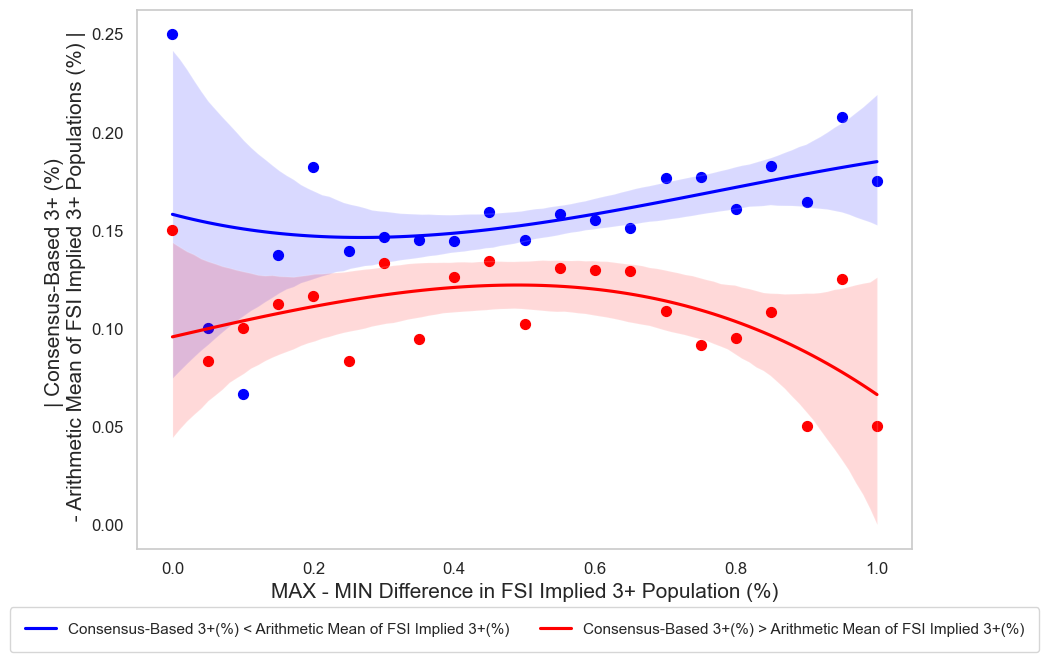

In [32]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))

df = ipc_df_sub[ipc_df_sub['FSI_combination']!='FCS-RCSI-HHS-HDDS'].copy()
#y-axis
df['diff']    = (df['phase3_plus_up'] - df['average3_up']).round(2)
df['diff_abs']= (abs(df['phase3_plus_up'] - df['average3_up'])).round(2)

# X-axis
fsi_set = ['FCS_3plus_up',
 'rCSI_3plus_up',
 'hhs_3plus_up',
 'lcs_3plus_up',
 'hdds_3plus_up']

df['diff_minmax'] = (df[fsi_set].max(axis = 1) - df[fsi_set].min(axis = 1)).round(2)
df['fi_sd'] = (df[fsi_set].std(axis = 1)).round(2)

df['obs-avg'] = np.where(df['diff']>0,'positive','negative')
df['obs-avg'] = np.where(df['diff']==0,'no difference',df['obs-avg'])


df = df[~df['FSI_combination'].isin([df['FSI_combination'].unique()[-1]])]

sns.regplot(data = df[df['obs-avg']=='negative'], # drop no difference case
           x='diff_minmax',y='diff_abs',
            label = 'Consensus-Based 3+ (%) < Averaged FSI implied 3+ (%)',x_estimator = np.mean, x_ci = None, color = 'blue',
           order = 3,)

sns.regplot(data = df[df['obs-avg']=='positive'], # drop no difference case
           x='diff_minmax',y='diff_abs', 
            label = 'Consensus-Based 3+ (%) > Averaged FSI Implied 3+ (%)',x_estimator = np.mean, x_ci = None, color = 'red',
           order = 3)


#ax.legend(['no difference','positive','negative',], fontsize = 10)
ax.set_ylabel(f'| Consensus-Based 3+ (%) \n - Arithmetic Mean of FSI Implied 3+ Populations (%) |', fontsize = 15)
ax.set_xlabel(f'MAX - MIN Difference in FSI Implied 3+ Population (%)', fontsize = 15)

for label in ax.get_xticklabels():
    label.set_fontsize(12)
for label in ax.get_yticklabels():
    label.set_fontsize(12)

ax.legend(['Consensus-Based 3+(%) < Arithmetic Mean of FSI Implied 3+(%)', 'Consensus-Based 3+(%) > Arithmetic Mean of FSI Implied 3+(%)'], 
          bbox_to_anchor=(0.5, -0.15), ncol = 4, borderpad = 1, loc = 'center', fontsize = 11, title_fontsize = 11  )


#ax.set_title('Difference between Actual IPC 3+ & Arithmatic Mean of FS indicators ' , fontsize =15)
ax.grid(False)

#plt.savefig(home +r'\figures\final_fig_update_1223\figure22.png', dpi = 300)

# Figure A11. Relationship between the HFA and the Difference in Consensus-Based and FSI implied 3+ Population Estimates (%)

In [33]:
# Load AFG_IPC with Humanitarian Food Assistance Data
afg_df = pd.read_csv(home+r'\stores\data\afg_df_hfa.csv')
afg_df['gap3'] = afg_df['phase3_plus_up'] - afg_df['average3_up']
afg_df

,Unnamed: 0,FCS_3plus_up,rCSI_3plus_up,hhs_3plus_up,lcs_3plus_up,hdds_3plus_up,phase3_plus_up,average3_up,overall_phase,yearmon,U-R,HFA-Number-Current,HFA-Percent-Current,HFA-Kcal-Perc-Current,HFA_total_Current,gap3
0,0,0.95,0.30,0.75,0.55,0.80,0.55,0.65,4.0,2022-03,Rural,671344.2399999999,0.479118,0.75,0.35925,-0.10
1,1,1.00,0.30,0.85,0.70,0.90,0.55,0.75,4.0,2022-03,Rural,383041.54,0.524308,0.75,0.39300,-0.20
2,2,0.95,0.35,0.45,0.95,0.65,0.40,0.65,3.0,2022-03,Rural,298685.94,0.277298,0.50,0.13850,-0.25
3,3,0.90,0.20,0.40,0.50,0.55,0.40,0.50,3.0,2022-03,Urban,91534.37999999999,0.336980,0.75,0.25275,-0.10
4,4,0.95,0.25,0.70,0.65,0.85,0.55,0.70,4.0,2022-03,Rural,614381.1799999999,0.453079,0.75,0.33975,-0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,0.65,0.25,0.35,0.70,0.50,0.25,0.50,3.0,2021-09,Urban,6444,0.080000,0.50,0.04000,-0.25
176,176,0.40,0.10,0.50,0.15,0.50,0.25,0.35,3.0,2021-09,Rural,61373,0.060000,0.50,0.03000,-0.10
177,177,1.00,0.40,0.40,0.75,0.85,0.60,0.65,4.0,2021-09,Rural,1402,0.000000,0.50,0.00000,-0.05
178,178,0.50,0.35,0.35,0.75,0.50,0.40,0.50,3.0,2021-09,Rural,.,0.000000,0.50,0.00000,-0.10


                            OLS Regression Results                            
Dep. Variable:                   gap3   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.064
Date:                Fri, 04 Oct 2024   Prob (F-statistic):             0.0818
Time:                        00:18:36   Log-Likelihood:                 153.44
No. Observations:                 180   AIC:                            -302.9
Df Residuals:                     178   BIC:                            -296.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0615      0.01

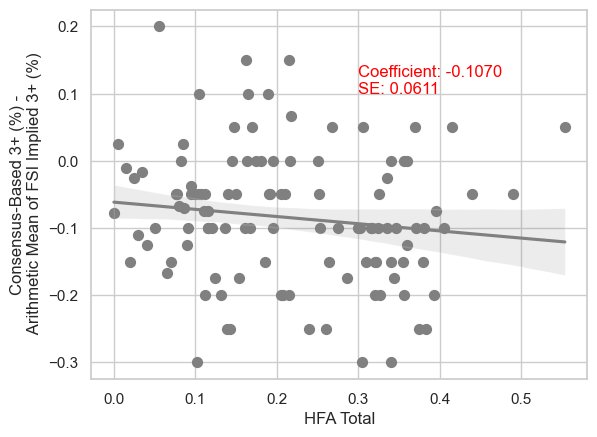

In [34]:
import statsmodels.api as sm
# Assuming resid_anal_df_afg_hfa is your DataFrame and 'HFA_total_Current' and 'gap3' are columns
df_filtered = afg_df.dropna(subset=['gap3', 'HFA_total_Current'])

# Define your independent variables (add a constant to the model for the intercept)
X = sm.add_constant(df_filtered['HFA_total_Current'])
y = df_filtered['gap3']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model to get a comprehensive overview, including coefficients and standard errors
print(model.summary())

# If you just want the coefficients and standard errors directly
coefficients = model.params
standard_errors = model.bse

print(f"Coefficients:\n{coefficients}\n")
print(f"Standard Errors:\n{standard_errors}\n")


# Your existing regplot code
ax = sns.regplot(data=df_filtered,
                 x='HFA_total_Current', y='gap3', 
                 #label='Consensus-Based 3+ (%) - Averaged FSI Implied 3+ (%)',
                 x_estimator=np.mean, x_ci=None, color='gray',
                 order=1)
ax.set_ylabel('Consensus-Based 3+ (%) -\n Arithmetic Mean of FSI Implied 3+ (%)')
ax.set_xlabel('HFA Total')
#plt.legend()

# Display coefficients and standard errors on the plot
# Adjust the x and y values to position your text appropriately
plt.text(x=0.3, y=0.1, 
         s=f'Coefficient: {coefficients["HFA_total_Current"]:.4f}\nSE: {standard_errors["HFA_total_Current"]:.4f}', 
         color='red')

plt.show()



# Figure A12. Observed and estimated distributions of IPC assessments defined by the proportion of population in phase 4+: 4, 5, 6, 7th polynomial counterfactual

In [35]:
# Set Data and Key Parameters
np.random.seed(123)  # Set seed for reproducibility
num_simulations = 500  # Number of simulations to run

# Replacing below parameter will recreate Figure A1
###################################################################################
poly_degree = 4  # 3, 5, 6, 7
###################################################################################

var = 'phase4plus_perc'  # Column name to be analyzed

# Prepare the Data
sub_df = rounded_df.copy()  # Copy the original dataframe for analysis
data = sub_df[f'{var}']  # Extract the data from the specified column
data_size = len(data)

# Step 1: Original Density Setup
zstar = 0.20  # Exclusion threshold value for bin filtering in simulations
binwidth = 0.05  # Width of each bin for histogramming data

# Create bins and bin midpoints for histogram calculations
bins_orig = np.arange(0, 1 + binwidth, binwidth)  # Define the bin edges for original data
binned_data_orig, _ = np.histogram(data.round(2), bins_orig.round(2))  # Histogram the original data
bin_midpoints_orig = (bins_orig[:-1] + bins_orig[1:]) / 2  # Calculate midpoints of the original bins

# Create bins and midpoints for simulation purposes
bins = np.arange(0, 1 + binwidth, binwidth)  # Define bins for the simulations
bin_midpoints = ((bins[:-1] + bins[1:]) / 2).round(3)  # Calculate midpoints of the bins

############## Simulation 1 ##################

# Initialize arrays to store polynomial coefficients for each exclusion
coefficients_matrix_125 = np.zeros((num_simulations, 20))  # 10% excluded
coefficients_matrix_175 = np.zeros((num_simulations, 20))  # 15% excluded
coefficients_matrix_225 = np.zeros((num_simulations, 20))  # 20% excluded
coefficients_matrix_275 = np.zeros((num_simulations, 20))  # 25% excluded
coefficients_matrix_325 = np.zeros((num_simulations, 20))  # 30% excluded

# Define the bin_midpoints to exclude in each set of simulations
exclude_points = [0.175, 0.225, 0.275, 0.325]  # Exclude these midpoints one at a time

# Loop through the exclusion points and perform simulations
for k in range(len(exclude_points)):
    print('Excluded points: ', exclude_points[k] - 0.025)
    
    for j in range(num_simulations):
        # Simulate a subset of data
        simulated_data = data.sample(len(data))
        
        # Bin the simulated data
        binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))
        
        # Filter out the bin corresponding to the excluded point
        filtered_midpoints = bin_midpoints[bin_midpoints != exclude_points[k]]
        filtered_counts = binned_data[bin_midpoints != exclude_points[k]]
        
        # Polynomial fitting on the filtered data
        coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
        poly_func = np.poly1d(coefficients)  # Create polynomial function from coefficients
        
        # Generate points along the polynomial curve
        x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
        y_poly = poly_func(x_poly)
        
        # Set negative values to 0 for valid probability density
        y_poly = np.where(y_poly < 0, 0, y_poly)
        
        # Store the polynomial values in the corresponding matrix
        if k == 0:
            coefficients_matrix_175[j, :] = y_poly
        elif k == 1:
            coefficients_matrix_225[j, :] = y_poly
        elif k == 2:
            coefficients_matrix_275[j, :] = y_poly
        else:
            coefficients_matrix_325[j, :] = y_poly

    print('Filtered_midpoints: ', filtered_midpoints - 0.025)

# Combine coefficient matrices from all exclusions into a single 3D array
all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                     coefficients_matrix_275, coefficients_matrix_325))
#print(all_coefficients_matrix.shape)

# Compute mean of all coefficients across simulations
mean_coefficients1 = np.mean(all_coefficients_matrix, axis=0)

# Calculate standard devs for the coefficients
std_devs1 = np.std(all_coefficients_matrix, axis=0, ddof=1)

############## Simulation 2 ##################
num_simulations = num_simulations * 4 #To make the number of simulations comparable with bin-excluded #1 simulation

# Initialize an array for storing coefficients from Simulation 2
coefficients_matrix2 = np.zeros((num_simulations, 20))

# Perform the second set of simulations
for j in range(num_simulations):
    simulated_data = data.sample(len(data), replace = True)  # Simulate data sample
    #print('simul2:', len(data))
    binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))  # Bin the simulated data

    # Polynomial fitting
    coefficients = np.polyfit(bin_midpoints, binned_data, poly_degree)
    poly_func = np.poly1d(coefficients)
    x_poly = np.linspace(min(bin_midpoints), max(bin_midpoints), 20)
    y_poly = poly_func(x_poly)

    # Replace negative values with 0
    y_poly = np.where(y_poly < 0, 0, y_poly)
    
    coefficients_matrix2[j, :] = y_poly

#print('Simul 2: ', bin_midpoints - 0.025)
# Compute mean and standard devs for the second simulation

mean_coefficients2 = np.mean(coefficients_matrix2, axis=0)
std_devs2 = np.std(coefficients_matrix2, axis=0, ddof=1)

############## Simulation 3 ##################

# Initialize an array to store coefficients for Simulation 3
coefficients_matrix3 = np.zeros((num_simulations, 20))

# Perform the third simulation
for j in range(num_simulations):
    simulated_data = data.sample(len(data), replace = True)  # Simulate data sample
    binned_data, _ = np.histogram(simulated_data.round(2), bins.round(2))  # Bin the simulated data

    # Exclude bins around the threshold zstar
    filtered_midpoints = bin_midpoints[(bin_midpoints < zstar - binwidth) | (bin_midpoints > zstar + binwidth)]
    filtered_counts = binned_data[(bin_midpoints < zstar - binwidth) | (bin_midpoints > zstar + binwidth)]
    
    # Polynomial fitting on filtered data
    coefficients = np.polyfit(filtered_midpoints, filtered_counts, poly_degree)
    poly_func = np.poly1d(coefficients)
    x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
    y_poly = poly_func(x_poly)

    # Replace negative values with 0
    y_poly = np.where(y_poly < 0, 0, y_poly)

    coefficients_matrix3[j, :] = y_poly

# Compute mean and standard devs for the third simulation
mean_coefficients3 = np.mean(coefficients_matrix3, axis=0)
std_devs3 = np.std(coefficients_matrix3, axis=0, ddof=1)

Excluded points:  0.15
Filtered_midpoints:  [0.   0.05 0.1  0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.2
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.25
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
Excluded points:  0.3
Filtered_midpoints:  [0.   0.05 0.1  0.15 0.2  0.25 0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


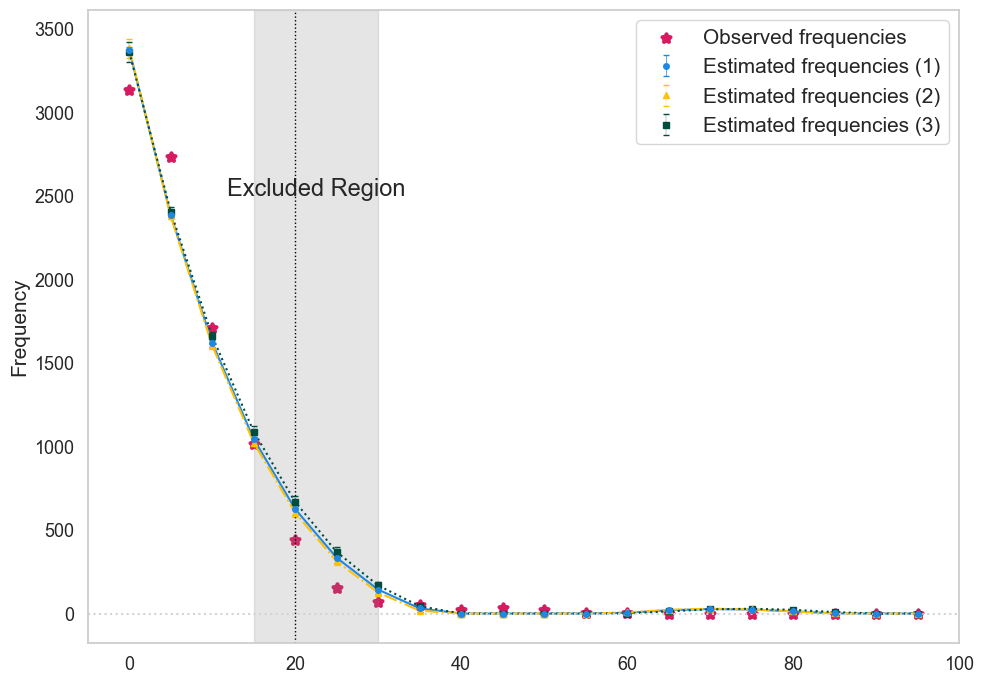

In [36]:
# Create a DataFrame directly from a dictionary
agg_df = pd.DataFrame({
    'bins': bin_midpoints - 0.025,
    'binned_data_orig': binned_data_orig,
    'mean_coefficients': mean_coefficients1,
    'std_devs': std_devs1
})

agg_df['excess_mass'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])
agg_df['excess_mass_perc'] = (agg_df['binned_data_orig'] - agg_df['mean_coefficients'])/agg_df['mean_coefficients']


# Create subplots
fig, axs = plt.subplots(1, figsize = (10,7))
#fig.subplots_adjust(wspace=0.5) 

# Plot on the first subplot
handle0 = axs.scatter(bin_midpoints_orig-0.025, binned_data_orig, 
                      label="Binned Data", color='#D81B60', marker='*', linewidth=3)

# Plot on the second subplot

# First, store each errorbar call in a variable to create custom handles
handle3 = axs.errorbar(bin_midpoints-0.025, mean_coefficients3, yerr=std_devs3*2, fmt='s', markersize=4, 
                color='#004D40', ecolor='#004D40', elinewidth=0.2, capsize=2)
handle2 = axs.errorbar(bin_midpoints-0.025, mean_coefficients2, yerr=std_devs2*2, fmt='^', markersize=4,
                color='#FFC107', ecolor='#FFC107', elinewidth=0.2, capsize=2)
handle1 = axs.errorbar(bin_midpoints-0.025, mean_coefficients1, yerr=std_devs1*2, fmt='o', markersize=4,
                color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2)

# Now create the legend explicitly with the desired order
axs.legend([handle0, handle1, handle2, handle3], 
              [f'Observed frequencies', 
                f'Estimated frequencies (1)', 
               f'Estimated frequencies (2)', 
               f'Estimated frequencies (3)'
              ], loc="upper right", ncol=1, fontsize=15)

axs.plot(bin_midpoints-0.025, mean_coefficients1, color='#1E88E5',)
axs.plot(bin_midpoints-0.025, mean_coefficients2, color='#FFC107', linestyle = '-.')
axs.plot(bin_midpoints-0.025, mean_coefficients3, color='#004D40', linestyle = ':')
axs.axvline(x=0.20, color='black', alpha=1, linestyle=':', linewidth = 1)
axs.axhline(y=0.0, color='lightgray', linestyle = ':')


# Adjust x-ticks if needed (commented out as there's no clear definition for `locations`)
axs.axvspan(0.15, 0.30, color='gray', alpha=0.2)
locations = np.arange(0, 1.2, 0.2) 
axs.set_xticks(locations)
axs.set_xticklabels(np.arange(0, 120, 20))
axs.set_xlim([-0.05, 1.0])
axs.annotate(f"Excluded Region", (0.225, 2500), ha = 'center', fontsize = 17)

##################################################################3
x_range = [0.15, 0.20, 0.25, 0.30]
x_beg = 4
x_end = 8

# Create a normalizer object which will map the data values (mean_coefficients1) to the range [0,1] for color mapping
actual_colors = [to_hex(viridis(np.linspace(0, 1, len(colors))[i])) if color == 'viridis_r' else 'lightgray' for i, color in enumerate(colors)]

# Bar plot
locations = np.arange(0, 1.2, 0.2) 

axs.tick_params(axis='y', labelsize=13) 
axs.tick_params(axis='x', labelsize=13)
axs.set_ylabel('Frequency', fontsize=15)
axs.grid(False)

plt.tight_layout()
plt.show()



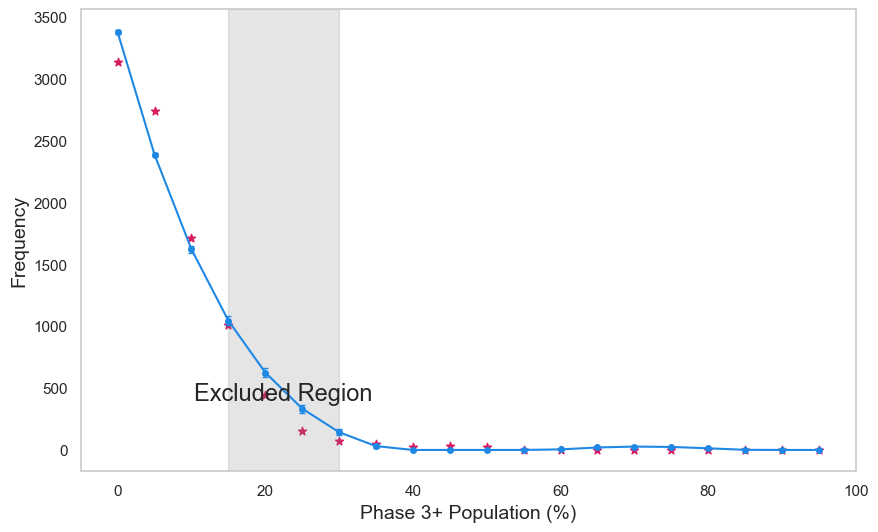

In [37]:
#Creating Polynomial Simulation Class

class PolynomialSimulation:
    def __init__(self, data, var, poly_degree, num_simulations=500, binwidth=0.05, seed=1234):
        """
        Initializes the class with necessary parameters and data.
        
        :param data: DataFrame containing the data for simulation.
        :param var: The variable (column name) in the DataFrame to analyze.
        :param num_simulations: Number of Simulations to run.
        :param poly_degree: Degree of the polynomial for curve fitting.
        :param binwidth: Bin width for histogram calculations.
        :param seed: Seed for random number generator.
        """
        self.data = data
        self.var = var
        self.num_simulations = num_simulations
        self.poly_degree = poly_degree
        self.binwidth = binwidth
        self.seed = seed
        self.binned_data_orig = None
        self.bin_midpoints_orig = None
        self.mean_coefficients1 = None
        self.std_devs1 = None

        # Set the random seed for reproducibility
        np.random.seed(self.seed)
        
        # Prepare bins for original and simulated data
        self.bins = np.arange(0, 1 + self.binwidth, self.binwidth)
        self.bin_midpoints = ((self.bins[:-1] + self.bins[1:]) / 2).round(3)
        
    def prepare_data(self):
        """
        Prepare and store the original histogram of the variable.
        """
        # Copy the relevant column data from the DataFrame
        sub_df = self.data.copy()
        data = sub_df[self.var]
        
        # Bin the original data
        self.binned_data_orig, _ = np.histogram(data.round(2), self.bins.round(2))
        self.bin_midpoints_orig = (self.bins[:-1] + self.bins[1:]) / 2
        
    def run_simulations(self):
        """
        Run simulations, performing polynomial fitting for each exclusion point.
        """
        # Prepare data for simulation
        data = self.data[self.var]
        data_size = len(data)
        
        # Initialize arrays for storing coefficients for each exclusion point
        coefficients_matrix_175 = np.zeros((self.num_simulations, 20))
        coefficients_matrix_225 = np.zeros((self.num_simulations, 20))
        coefficients_matrix_275 = np.zeros((self.num_simulations, 20))
        coefficients_matrix_325 = np.zeros((self.num_simulations, 20))
        
        # Define exclusion points
        exclude_points = [0.175, 0.225, 0.275, 0.325]
        
        # Loop through exclusion points and perform simulations
        for k, exclude_point in enumerate(exclude_points):
            for j in range(self.num_simulations):
                # Simulate a subset of the data
                simulated_data = data.sample(data_size)
                binned_data, _ = np.histogram(simulated_data.round(2), self.bins.round(2))

                # Exclude specified midpoints
                filtered_midpoints = self.bin_midpoints[self.bin_midpoints != exclude_point]
                filtered_counts = binned_data[self.bin_midpoints != exclude_point]

                # Perform polynomial fitting on the filtered data
                coefficients = np.polyfit(filtered_midpoints, filtered_counts, self.poly_degree)
                poly_func = np.poly1d(coefficients)
                x_poly = np.linspace(min(filtered_midpoints), max(filtered_midpoints), 20)
                y_poly = poly_func(x_poly)
                
                # Replace negative values with 0
                y_poly = np.where(y_poly < 0, 0, y_poly)

                # Store the coefficients in the appropriate matrix
                if k == 0:
                    coefficients_matrix_175[j, :] = y_poly
                elif k == 1:
                    coefficients_matrix_225[j, :] = y_poly
                elif k == 2:
                    coefficients_matrix_275[j, :] = y_poly
                else:
                    coefficients_matrix_325[j, :] = y_poly

        # Combine coefficient matrices into a single array
        all_coefficients_matrix = np.vstack((coefficients_matrix_175, coefficients_matrix_225, 
                                             coefficients_matrix_275, coefficients_matrix_325))

        # Compute mean and standard deviations across simulations
        self.mean_coefficients1 = np.mean(all_coefficients_matrix, axis=0)
        self.std_devs1 = np.std(all_coefficients_matrix, axis=0, ddof=1)
        
    def plot_results(self, x_label):
        """
        Plot the original histogram and the results of the simulations.
        """
        # Create a figure for plotting
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot original data (observed)
        ax.scatter(self.bin_midpoints_orig - 0.025, self.binned_data_orig, label="Binned Data", color='#D81B60', marker='*')

        # Plot simulated data (mean and error bars)
        ax.errorbar(self.bin_midpoints - 0.025, self.mean_coefficients1, yerr=self.std_devs1 * 2,
                    fmt='o', color='#1E88E5', ecolor='#1E88E5', elinewidth=0.5, capsize=2, markersize=4)
        ax.plot(self.bin_midpoints-0.025, self.mean_coefficients1, color='#1E88E5',)
        # Add plot labels and title
        #ax.set_title(f'Simulation for {self.var}', fontsize=16)
        ax.set_xlabel(x_label, fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        ax.axvspan(0.15, 0.30, color='gray', alpha=0.2)
        locations = np.arange(0, 1.2, 0.2) 
        ax.set_xticks(locations)
        ax.set_xticklabels(np.arange(0, 120, 20))
        ax.set_xlim([-0.05, 1.0])
        ax.annotate(f"Excluded Region", (0.225, 400), ha = 'center', fontsize = 17)

        # Add grid and show plot
        ax.grid(False)
        plt.show()

# Example usage:
# Assuming 'rounded_df' is your DataFrame and 'phase4plus_perc' is the column to analyze
sim = PolynomialSimulation(rounded_df, 'phase4plus_perc', 4)
sim.prepare_data()
sim.run_simulations()
sim.plot_results('Phase 3+ Population (%)')


# Figure A13. Histograms of rounded and unrounded IPC assessments defined by the proportion of population in phase 3+ (%)

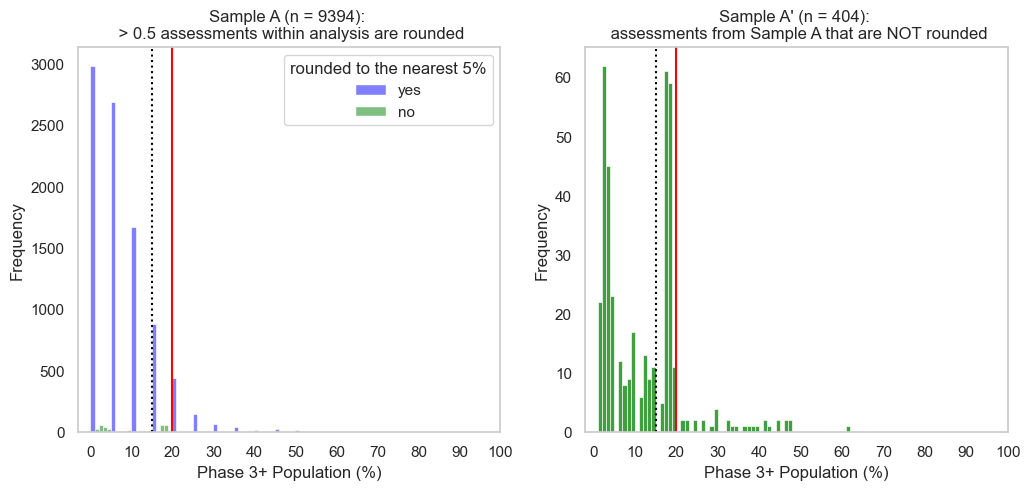

In [38]:
fig, ax = plt.subplots(1,2, figsize =  (12,5))

var = 'phase4plus_perc'

rounded_df['rounded to the nearest 5%'] = np.where(rounded_df[var].isin(roundnumber), 'yes','no')

sns.histplot(data=rounded_df, x=var, binwidth = 0.00999, ax = ax[0], hue = 'rounded to the nearest 5%', kde = False, 
             palette ={'yes':'blue','no':'green'})
#sns.histplot(data=plot_df, x=var, binwidth = 0.00999, ax = ax1, hue = 'rounded to the nearest 5%', kde = False, palette ={'yes':'orange','no':'purple'})

ax[0].axvline(x= 0.2, color  = 'red')
ax[0].axvline(x= 0.15, color  = 'black', linestyle = ':')
ax[0].set_xlabel('Phase 3+ Population (%)', fontsize = 12)
ax[0].set_ylabel('Frequency', fontsize = 12)
ax[0].set_title(f'Sample A (n = {len(rounded_df)}): \n > 0.5 assessments within analysis are rounded')

locations = np.arange(0, 1.1, 0.1)
ax[0].set_xticks(locations)
ax[0].set_xticklabels(np.arange(0, 110, 10))

sns.histplot(rounded_df[~rounded_df[var].isin(np.arange(0,1,0.05).round(2))][var], binwidth = 0.00999, ax = ax[1], kde = False,  
             color = 'green')
ax[1].axvline(x= 0.2, color  = 'red')
ax[1].axvline(x= 0.15, color  = 'black', linestyle = ':')
ax[1].set_xlabel('Phase 3+ Population (%)', fontsize = 12)
ax[1].set_ylabel('Frequency', fontsize = 12)
ax[1].set_title(f"Sample A' (n = {len(rounded_df[~rounded_df[var].isin(np.arange(0,1,0.05).round(2))][var])}): \n assessments from Sample A that are NOT rounded")


locations = np.arange(0, 1.1, 0.1)
ax[1].set_xticks(locations)
ax[1].set_xticklabels(np.arange(0, 110, 10))

ax[0].grid(False)
ax[1].grid(False)


# Figure A14. IPC Undercount and Overcount relative to FSI mean by country

['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']


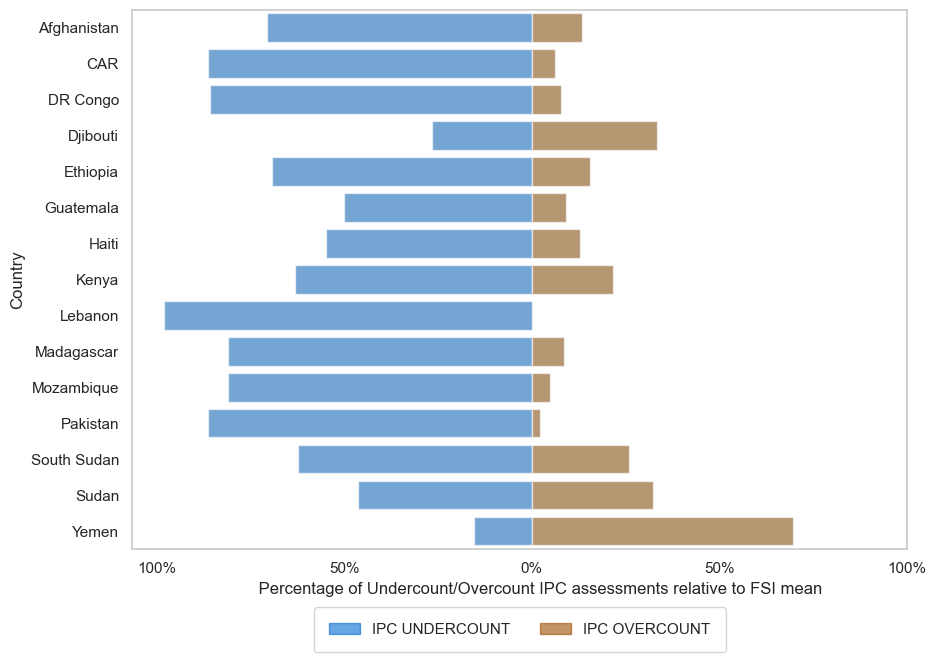

In [39]:
df = ipc_df_sub[ipc_df_sub['FSI_combination']!='FCS-RCSI-HHS-HDDS'].copy()
#y-axis
df['diff']    = (df['phase3_plus_up'] - df['average3_up']).round(2)
df['diff_abs']= (abs(df['phase3_plus_up'] - df['average3_up'])).round(2)

# X-axis
fsi_set = ['FCS_3plus_up',
 'rCSI_3plus_up',
 'hhs_3plus_up',
 'lcs_3plus_up',
 'hdds_3plus_up']

print(fsi_set)
df['diff_minmax'] = (df[fsi_set].max(axis = 1) - df[fsi_set].min(axis = 1)).round(2)
df['fi_sd'] = (df[fsi_set].std(axis = 1)).round(2)

df['obs-avg'] = np.where(df['diff']>0,'positive','negative')
df['obs-avg'] = np.where(df['diff']==0,'no difference',df['obs-avg'])


df_conserve_count_df = df.groupby('country')['obs-avg'].value_counts(normalize = True).reset_index(name='normalized_counts')
df_conserve_count_df = df_conserve_count_df[df_conserve_count_df['obs-avg']!='no difference']
df_conserve_count_df['normalized_counts'] = np.where(df_conserve_count_df['obs-avg']=='negative', -df_conserve_count_df['normalized_counts'], df_conserve_count_df['normalized_counts'])

wide_df = df_conserve_count_df.pivot(index='country', columns='obs-avg', values='normalized_counts').reset_index()

sorted(wide_df['country'].unique())

agg_level = 'country' # 'index' refers to 'Country' X 'Round'
df_conserve_count_df = df.groupby(agg_level)['obs-avg'].value_counts(normalize = True).reset_index(name='normalized_counts')
df_conserve_count_df = df_conserve_count_df[df_conserve_count_df['obs-avg']!='no difference']
df_conserve_count_df['normalized_counts'] = np.where(df_conserve_count_df['obs-avg']=='negative', -df_conserve_count_df['normalized_counts'], df_conserve_count_df['normalized_counts'])

wide_df = df_conserve_count_df.pivot(index=agg_level, columns='obs-avg', values='normalized_counts').reset_index().rename(columns = {'negative':'undercount','positive':'overcount'})
wide_df

fig, ax = plt.subplots(figsize=(10, 7))  # For example, a 12 by 8 inches figure

ax1 = sns.barplot(x='undercount', y=agg_level, data=wide_df, order=sorted(wide_df[agg_level].unique()), color = '#006CD1', alpha = 0.6)

ax2 = sns.barplot(x='overcount', y=agg_level, data=wide_df, order=sorted(wide_df[agg_level].unique()), color = '#994F00', alpha = 0.6)

# Create custom legend handles
overcount_patch = mpatches.Patch(color='#994F00', label='IPC OVERCOUNT', alpha = 0.6)
undercount_patch = mpatches.Patch(color='#006CD1', label='IPC UNDERCOUNT', alpha = 0.6)


# Add custom legend to the plot with these handles
plt.legend(handles=[undercount_patch, overcount_patch], 
           bbox_to_anchor=(0.5, -0.15), ncol=2, borderpad=1, loc='center', fontsize=11, title_fontsize=10)


# Show 

plt.xlabel("         Percentage of Undercount/Overcount IPC assessments relative to FSI mean", loc = 'center', fontsize = 12)
plt.ylabel("Country", fontsize = 12)
plt.xticks(ticks=[-1, -0.5, 0, 0.5, 1], labels=['100%', '50%', '0%', '50%', '100%'])
#plt.yticks(ticks = np.arange(0, wide_df[agg_level].nunique(),1), labels=[t.split(",")[0].strip(" ('") + ' x ' + t.split(",")[1].strip(" ')") for t in sorted(wide_df[agg_level].unique())])

plt.grid(False)


# Figure A15. IPC Undercount and Overcount relative to FSI mean by country X Round

['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']


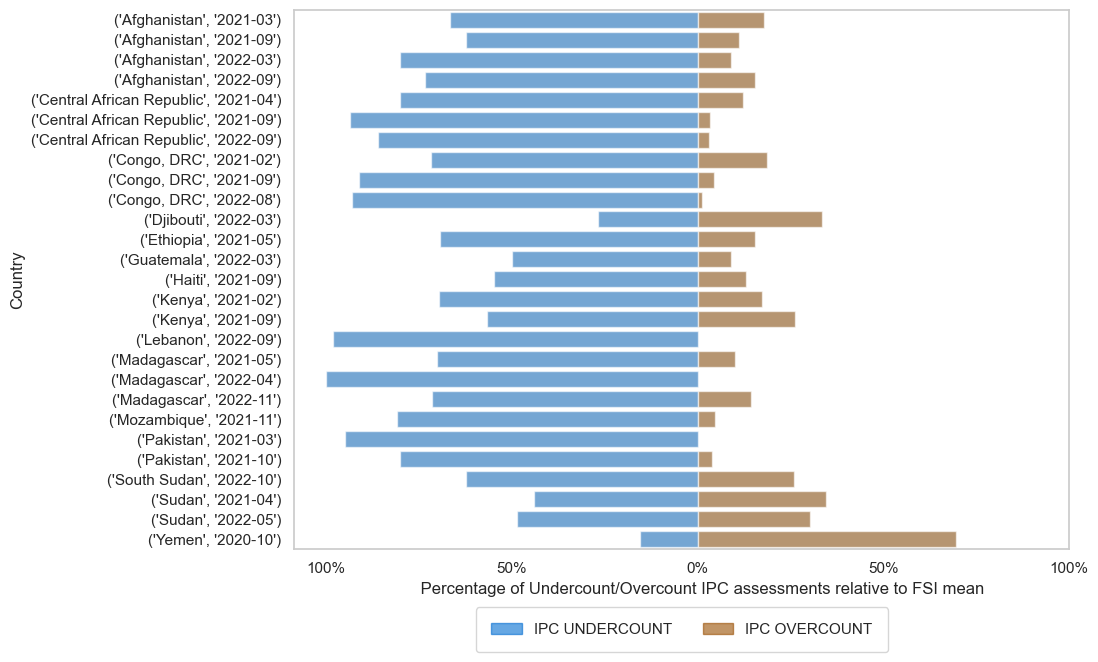

In [40]:
df = ipc_df_sub[ipc_df_sub['FSI_combination']!='FCS-RCSI-HHS-HDDS'].copy()
#y-axis
df['diff']    = (df['phase3_plus_up'] - df['average3_up']).round(2)
df['diff_abs']= (abs(df['phase3_plus_up'] - df['average3_up'])).round(2)

# X-axis
fsi_set = ['FCS_3plus_up',
 'rCSI_3plus_up',
 'hhs_3plus_up',
 'lcs_3plus_up',
 'hdds_3plus_up']

print(fsi_set)
df['diff_minmax'] = (df[fsi_set].max(axis = 1) - df[fsi_set].min(axis = 1)).round(2)
df['fi_sd'] = (df[fsi_set].std(axis = 1)).round(2)

df['obs-avg'] = np.where(df['diff']>0,'positive','negative')
df['obs-avg'] = np.where(df['diff']==0,'no difference',df['obs-avg'])


df_conserve_count_df = df.groupby('country')['obs-avg'].value_counts(normalize = True).reset_index(name='normalized_counts')
df_conserve_count_df = df_conserve_count_df[df_conserve_count_df['obs-avg']!='no difference']
df_conserve_count_df['normalized_counts'] = np.where(df_conserve_count_df['obs-avg']=='negative', -df_conserve_count_df['normalized_counts'], df_conserve_count_df['normalized_counts'])

wide_df = df_conserve_count_df.pivot(index='country', columns='obs-avg', values='normalized_counts').reset_index()

sorted(wide_df['country'].unique())

agg_level = 'index' # 'index' refers to 'Country' X 'Round'
df_conserve_count_df = df.groupby(agg_level)['obs-avg'].value_counts(normalize = True).reset_index(name='normalized_counts')
df_conserve_count_df = df_conserve_count_df[df_conserve_count_df['obs-avg']!='no difference']
df_conserve_count_df['normalized_counts'] = np.where(df_conserve_count_df['obs-avg']=='negative', -df_conserve_count_df['normalized_counts'], df_conserve_count_df['normalized_counts'])

wide_df = df_conserve_count_df.pivot(index=agg_level, columns='obs-avg', values='normalized_counts').reset_index().rename(columns = {'negative':'undercount','positive':'overcount'})
wide_df

fig, ax = plt.subplots(figsize=(10, 7))  # For example, a 12 by 8 inches figure

ax1 = sns.barplot(x='undercount', y=agg_level, data=wide_df, order=sorted(wide_df[agg_level].unique()), color = '#006CD1', alpha = 0.6)

ax2 = sns.barplot(x='overcount', y=agg_level, data=wide_df, order=sorted(wide_df[agg_level].unique()), color = '#994F00', alpha = 0.6)

ax1.grid(False)
ax2.grid(False)
# Create custom legend handles
overcount_patch = mpatches.Patch(color='#994F00', label='IPC OVERCOUNT', alpha = 0.6)
undercount_patch = mpatches.Patch(color='#006CD1', label='IPC UNDERCOUNT', alpha = 0.6)


# Add custom legend to the plot with these handles
plt.legend(handles=[undercount_patch, overcount_patch], 
           bbox_to_anchor=(0.5, -0.15), ncol=2, borderpad=1, loc='center', fontsize=11, title_fontsize=10)

# Show 

plt.xlabel("         Percentage of Undercount/Overcount IPC assessments relative to FSI mean", loc = 'center', fontsize = 12)
plt.ylabel("Country", fontsize = 12)
plt.xticks(ticks=[-1, -0.5, 0, 0.5, 1], labels=['100%', '50%', '0%', '50%', '100%'])
#plt.yticks(ticks = np.arange(0, wide_df[agg_level].nunique(),1), labels=[t.split(",")[0].strip(" ('") + ' x ' + t.split(",")[1].strip(" ')") for t in sorted(wide_df[agg_level].unique())])

plt.grid(False)


# Table A4. Determinants of FSI availability: A logistic regression across 32 countries

Because we only observe FSI data for a subset of our assessments, we investigate the generalizability of our results from the FSI analyses by evaluating whether we observe systematic differences between the samples with and without FSI data (sample C versus sample A from Table A1 in the main text). We employ a logistic regression to explore if and how various country-level characteristics —including GDP, measured in purchasing power parity (IMF 2024), ln(conflict-related fatalities)  (Raleigh et al. 2010), democratic measures (EIU 2022), ln(average population) (World Bank 2024), and the average phase classification at the country level— predict the likelihood of a country having underlying FSI information (1 if a country has FSI information, 0 otherwise). We find that locations are generally similar across these dimensions, with the notable distinction being higher conflict-related fatalities observed in areas with FSI data.

## Democratic Index
data source: https://ourworldindata.org/grapher/democracy-index-eiu?tab=table

In [41]:
# IPC country list

country_codes = {
    'Afghanistan': 'AFG',
    'Bangladesh': 'BGD',
    'Pakistan': 'PAK',
    'Timor-Leste': 'TLS',
    'Burundi': 'BDI',
    'Central African Republic': 'CAF',
    'Congo, DRC': 'COD',  # Democratic Republic of the Congo
    'Djibouti': 'DJI',
    'Ethiopia': 'ETH',
    'Kenya': 'KEN',
    'Somalia': 'SOM',
    'South Sudan': 'SSD',
    'Sudan': 'SDN',
    'Tanzania': 'TZA',
    'Uganda': 'UGA',
    'Angola': 'AGO',
    'Eswatini': 'SWZ',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Malawi': 'MWI',
    'Mozambique': 'MOZ',
    'Namibia': 'NAM',
    'South Africa': 'ZAF',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE',
    'Dominican Republic': 'DOM',
    'El Salvador': 'SLV',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Honduras': 'HND',
    'LAC Region (tri-National)': 'LAC',  # This is not a country, hence no ISO code
    'Lebanon': 'LBN',
    'Yemen': 'YEM'
}

iso_codes_3_org = sorted([code for code in country_codes.values() if code is not None])

# Now, to remove 'AFG', 'SSD', and 'ETH' from the list, you can do it with a loop or list comprehension:
iso_codes_3 = [code for code in iso_codes_3_org if code not in ('AFG', 'SSD', 'ETH')]


print(iso_codes_3_org)

['AFG', 'AGO', 'BDI', 'BGD', 'CAF', 'COD', 'DJI', 'DOM', 'ETH', 'GTM', 'HND', 'HTI', 'KEN', 'LAC', 'LBN', 'LSO', 'MDG', 'MOZ', 'MWI', 'NAM', 'PAK', 'SDN', 'SLV', 'SOM', 'SSD', 'SWZ', 'TLS', 'TZA', 'UGA', 'YEM', 'ZAF', 'ZMB', 'ZWE']


In [42]:
# Load the Democracy Index dataset from a CSV file
# The dataset likely contains country-level democracy index data from the Economist Intelligence Unit (EIU)
democ_df = pd.read_csv(home + r'\stores\data\democracy-index-eiu.csv')

# Filter the dataframe to include only rows where the 'Code' (country code) is in the 'iso_codes_3_org' list
# Then rename relevant columns for easier analysis ('Code' -> 'countrycode', 'Year' -> 'year', 'Entity' -> 'country')
democ_ipc_df = democ_df[democ_df['Code'].isin(iso_codes_3_org)].rename(columns={
    'Code': 'countrycode',  # Rename the country code column
    'Year': 'year',  # Rename the year column
    'Entity': 'country'  # Rename the country name column
})

# Somalia (SOM) and South Sudan (SSD) have No Democracy Index (D-Index) 
# This line ensures that for these two countries, the 'democracy_eiu' column is set to 0
democ_ipc_df['democracy_eiu'] = np.where(democ_ipc_df['countrycode'].isin(['SOM', 'SSD']), 0, democ_ipc_df['democracy_eiu'])

# Print the unique country codes that are available in the filtered dataset, as well as the number of unique country codes
print('Demo Index Available Countries: ', democ_ipc_df['countrycode'].unique(), democ_ipc_df['countrycode'].nunique())

# Display the first few rows of the processed dataframe to inspect the data
democ_ipc_df.head()


Demo Index Available Countries:  ['AFG' 'AGO' 'BGD' 'BDI' 'CAF' 'COD' 'DJI' 'DOM' 'TLS' 'SLV' 'SWZ' 'ETH'
 'GTM' 'HTI' 'HND' 'KEN' 'LBN' 'LSO' 'MDG' 'MWI' 'MOZ' 'NAM' 'PAK' 'ZAF'
 'SDN' 'TZA' 'UGA' 'YEM' 'ZMB' 'ZWE'] 30


,country,countrycode,year,democracy_eiu
0,Afghanistan,AFG,2006,3.06
1,Afghanistan,AFG,2008,3.02
2,Afghanistan,AFG,2010,2.48
3,Afghanistan,AFG,2011,2.48
4,Afghanistan,AFG,2012,2.48


# IMF GDP per capita & OurWorldinData - populaion

https://ourworldindata.org/grapher/gdp-per-capita-worldbank?tab=table&time=2015..latest

https://ourworldindata.org/grapher/population?tab=table&time=2017..latest

https://www.imf.org/external/datamapper/NGDPDPC@WEO/OEMDC/ADVEC/WEOWORLD/YEM

In [43]:
# Load the IMF GDP dataset and rename the first column (which likely has no header) to 'country_name'
imf_gdp_df = pd.read_csv(home + r'\stores\data\imf-gdp-ppp.csv').rename(columns={'Unnamed: 0': 'country_name'})

# Convert the dataset from wide format to long format using pd.melt()
# This transforms the columns representing years (2017 to 2023) into a single 'year' column with corresponding 'gdp_ppp' values
imf_gdp_df_long = pd.melt(
    imf_gdp_df,
    id_vars=['country_name'],  # The identifier variable(s) that remain constant (in this case, 'country_name')
    value_vars=['2017', '2018', '2019', '2020', '2021', '2022', '2023'],  # The columns to be unpivoted (year columns)
    var_name='year',  # Name of the new column that holds the 'year' values
    value_name='gdp_ppp'  # Name of the new column that holds the 'gdp_ppp' values
)

# Create a dictionary to map country names to their respective ISO 3-digit country codes
# This mapping is based on how the IMF refers to the countries in its dataset
imf_names_to_codes = {
    'Afghanistan': 'AFG',
    'Angola': 'AGO',
    'Burundi': 'BDI',
    'Bangladesh': 'BGD',
    'Central African Republic': 'CAF',
    'Congo, Dem. Rep. of the': 'COD',  # Democratic Republic of Congo
    'Djibouti': 'DJI',
    'Dominican Republic': 'DOM',
    'Ethiopia': 'ETH',
    'Guatemala': 'GTM',
    'Honduras': 'HND',
    'Haiti': 'HTI',
    'Kenya': 'KEN',
    'Lebanon': 'LBN',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Mozambique': 'MOZ',
    'Malawi': 'MWI',
    'Namibia': 'NAM',
    'Pakistan': 'PAK',
    'Sudan': 'SDN',
    'El Salvador': 'SLV',
    'Somalia': 'SOM',
    'South Sudan, Republic of': 'SSD',
    'Eswatini': 'SWZ',
    'Timor-Leste': 'TLS',
    'Tanzania': 'TZA',
    'Uganda': 'UGA',
    'Yemen': 'YEM',
    'South Africa': 'ZAF',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE'
}

# Replace country names in the 'country_name' column with their corresponding ISO codes using the dictionary 'imf_names_to_codes'
imf_gdp_df_long['countrycode'] = imf_gdp_df_long['country_name'].replace(imf_names_to_codes)

# Filter the dataframe to include only rows where the 'countrycode' exists in the values of the 'imf_names_to_codes' dictionary
# This ensures that we keep only the relevant countries with valid codes
imf_gdp_df_final = imf_gdp_df_long[imf_gdp_df_long['countrycode'].isin(imf_names_to_codes.values())]

# Remove rows where 'gdp_ppp' has the value 'no data'
# This step cleans the dataset by removing invalid or missing GDP data
imf_gdp_df_final = imf_gdp_df_final[imf_gdp_df_final['gdp_ppp'] != 'no data']

# Convert the 'gdp_ppp' column from string to float for numerical analysis
imf_gdp_df_final['gdp_ppp'] = imf_gdp_df_final['gdp_ppp'].astype('float64')

# The final dataframe, 'imf_gdp_df_final', now contains:
# - Country names replaced by ISO 3-digit country codes
# - GDP (PPP) values for the years 2017-2023
# - Cleaned rows where GDP data is valid and in numerical format


In [44]:
# Pop
pop_df = pd.read_csv(home + r'\stores\data\population.csv').rename(columns = {'Population (historical estimates)':'population',
                                                                                       'Code':'countrycode',
                                                                                       'Year':'year',
                                                                                       'Entity':'country_name'})

pop_df = pop_df[(pop_df['year']>=2017) & (pop_df['countrycode'].isin(iso_codes_3_org))]


## Loading ACLED

API: https://apidocs.acleddata.com/generalities_section.html

ACLED country list: https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2019/01/ACLED_Country-and-Time-Period-coverage_updatedFeb2022.pdf

ACLED Access Guid: https://acleddata.com/acleddatanew/wp-content/uploads/2021/11/ACLED_Access-Guide_October-2020.pdf

In [45]:
# Load the ACLED result DataFrame from a CSV file containing country-level fatalities data
acled_result_df = pd.read_csv(home + r'\stores\data\country_level_fatalities_acled.csv')

# Create a dictionary to map country names to their corresponding 3-digit ISO country codes
# This mapping is used to standardize country names and ensure consistency when merging or analyzing data
country_codes_3_digit = {
    'Afghanistan': 'AFG',
    'Angola': 'AGO',
    'Bangladesh': 'BGD',
    'Burundi': 'BDI',
    'Central_African_Republic': 'CAF',  # CAR mapped to its ISO code
    'Congo_DRC': 'COD',  # DR Congo mapped to its ISO code
    'Djibouti': 'DJI',
    'Dominican_Republic': 'DOM',
    'El_Salvador': 'SLV',
    'Eswatini': 'SWZ',
    'Ethiopia': 'ETH',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Honduras': 'HND',
    'Kenya': 'KEN',
    'Lebanon': 'LBN',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Malawi': 'MWI',
    'Mozambique': 'MOZ',
    'Namibia': 'NAM',
    'Pakistan': 'PAK',
    'Somalia': 'SOM',
    'South_Africa': 'ZAF',  # South Africa's ISO code is ZAF
    'South_Sudan': 'SSD',
    'Sudan': 'SDN',
    'Tanzania': 'TZA',
    'Timor_Leste': 'TLS',  # Timor-Leste (East Timor)
    'Uganda': 'UGA',
    'Yemen': 'YEM',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE'
}

# Replace the country names in the 'country_name' column of the ACLED result DataFrame with their corresponding ISO country codes
# This ensures that country names are standardized using 3-digit ISO codes, which is crucial for consistent data merging and analysis
acled_result_df['countrycode'] = acled_result_df['country_name'].replace(country_codes_3_digit)

# Create a new column called 'index2' that serves as a unique identifier by combining 'countrycode' and 'yearmon'
# The 'set_index' method is used to create a multi-index using 'countrycode' and 'yearmon' (year-month)
# This will allow for more efficient lookups or merging operations when dealing with data across different countries and time periods
acled_result_df['index2'] = acled_result_df.set_index(['countrycode', 'yearmon']).index


## Load IPC Study Sample A (n = 9394)

In [46]:
# IPC Study Sample A
country_codes = {
    'Afghanistan': 'AFG',
    'Bangladesh': 'BGD',
    'Pakistan': 'PAK',
    'Timor-Leste': 'TLS',
    'Burundi': 'BDI',
    'Central African Republic': 'CAF',
    'Congo, DRC': 'COD',  # Democratic Republic of the Congo
    'Djibouti': 'DJI',
    'Ethiopia': 'ETH',
    'Kenya': 'KEN',
    'Somalia': 'SOM',
    'South Sudan': 'SSD',
    'Sudan': 'SDN',
    'Tanzania': 'TZA',
    'Uganda': 'UGA',
    'Angola': 'AGO',
    'Eswatini': 'SWZ',
    'Lesotho': 'LSO',
    'Madagascar': 'MDG',
    'Malawi': 'MWI',
    'Mozambique': 'MOZ',
    'Namibia': 'NAM',
    'South Africa': 'ZAF',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE',
    'Dominican Republic': 'DOM',
    'El Salvador': 'SLV',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Honduras': 'HND',
    'LAC Region (tri-National)': 'LAC',  # This is not a country, hence no ISO code
    'Lebanon': 'LBN',
    'Yemen': 'YEM'
}

rounded_df['countrycode'] = rounded_df['country_name'].replace(country_codes)
rounded_df['index2'] = rounded_df.set_index(['countrycode','yearmon']).index


ipc_study_df_uniq_country = rounded_df['countrycode'].unique()
ipc_study_df_uniq_index = rounded_df['index2'].unique()

print('Unique country from IPC Sample C:', ipc_study_df_uniq_country)

Unique country from IPC Sample C: ['AFG' 'BGD' 'PAK' 'TLS' 'BDI' 'CAF' 'COD' 'DJI' 'ETH' 'KEN' 'SOM' 'SSD'
 'SDN' 'TZA' 'UGA' 'AGO' 'SWZ' 'LSO' 'MDG' 'MWI' 'MOZ' 'NAM' 'ZAF' 'ZMB'
 'ZWE' 'DOM' 'SLV' 'GTM' 'HTI' 'HND' 'LAC' 'LBN' 'YEM']


## Load IPC Study Sample C (n = 1849)

In [47]:
# Load S
two_to_three_digit_codes = {
    'MG': 'MDG',  # Madagascar
    'ET': 'ETH',  # Ethiopia
    'DJ': 'DJI',  # Djibouti
    'LB': 'LBN',  # Lebanon
    'KE': 'KEN',  # Kenya
    'HT': 'HTI',  # Haiti
    'GT': 'GTM',  # Guatemala
    'YE': 'YEM',  # Yemen
    'PK': 'PAK',  # Pakistan
    'MZ': 'MOZ',  # Mozambique
    'SS': 'SSD',  # South Sudan
    'CD': 'COD',  # Congo, Democratic Republic of the
    'CF': 'CAF',  # Central African Republic
    'AF': 'AFG',  # Afghanistan
    'SD': 'SDN',  # Sudan
}


# Create necessary columns for merging
ipc_df_sub['countrycode'] = ipc_df_sub['country_code'].replace(two_to_three_digit_codes)
ipc_df_sub['year'] = ipc_df_sub['yearmon'].str[:4].astype('str')

ipc_df_sub['index2'] = ipc_df_sub.set_index(['countrycode','yearmon']).index


# Dictionary specifying replacements (FSI name -> IPC bigger sample name)
fsi_to_biggersample_replacements = {
    ('COD', '2022-08'): ('COD', '2022-07'),
    ('KEN', '2021-09'): ('KEN', '2021-07'),
    ('MDG', '2021-05'): ('MDG', '2021-04'),
    ('SDN', '2022-05'): ('SDN', '2022-04'),
    ('CAF', '2021-04'): ('CAF', '2020-09'), # 2021-04 projection updated for CAF 2020-09
    # Add more replacements as needed
}

# Apply replacements
ipc_df_sub['index2'] = ipc_df_sub['index2'].apply(lambda x: fsi_to_biggersample_replacements[x] if x in fsi_to_biggersample_replacements else x)

# Create list of countrycode and index2
ipc_study_fsi_df_uniq_country = ipc_df_sub['countrycode'].unique()
ipc_study_fsi_df_uniq_index = ipc_df_sub['index2'].unique()

print('Unique country from IPC Sample C:', ipc_study_fsi_df_uniq_country)


Unique country from IPC Sample C: ['MDG' 'ETH' 'DJI' 'LBN' 'KEN' 'HTI' 'GTM' 'YEM' 'PAK' 'MOZ' 'SSD' 'COD'
 'CAF' 'AFG' 'SDN']


In [48]:
# Indicate FSI available Country vs FSI available Country X Round
rounded_df['fsi_exist_country'] = np.where(rounded_df['countrycode'].isin(ipc_study_fsi_df_uniq_country),1, 0)
rounded_df['fsi_exist_index'] = np.where(rounded_df['index2'].isin(ipc_study_fsi_df_uniq_index),1, 0)

# Group By TWG or Country
twg_level_df = rounded_df[['fsi_exist_country','fsi_exist_index','year','countrycode','index2','yearmon','overall_phase']].drop_duplicates(subset = ['countrycode','index2'])
country_level_df = rounded_df[['fsi_exist_country','fsi_exist_index','year','countrycode','index2','yearmon','overall_phase']].drop_duplicates(subset = 'countrycode')

# This is the data that is used to generate Table A4 in the SI
country_level_df

,fsi_exist_country,fsi_exist_index,year,countrycode,index2,yearmon,overall_phase
0,1,0,2023,AFG,"(AFG, 2023-10)",2023-10,3.0
504,0,0,2023,BGD,"(BGD, 2023-03)",2023-03,3.0
521,1,0,2023,PAK,"(PAK, 2023-04)",2023-04,3.0
674,0,0,2022,TLS,"(TLS, 2022-11)",2022-11,3.0
688,0,0,2023,BDI,"(BDI, 2023-09)",2023-09,2.0
784,1,0,2023,CAF,"(CAF, 2023-09)",2023-09,3.0
1377,1,0,2023,COD,"(COD, 2023-07)",2023-07,3.0
2620,1,0,2023,DJI,"(DJI, 2023-03)",2023-03,3.0
2665,1,1,2021,ETH,"(ETH, 2021-05)",2021-05,3.0
2928,1,0,2023,KEN,"(KEN, 2023-07)",2023-07,2.0


In [49]:
# Assuming 'df' is your DataFrame
# List of years
years = range(2017, 2023)

# Data for new rows - This is necessary because EIU provides no Democracy Index for South Sudan and Somalia
new_rows = []
for year in years:
    new_rows.append({"country": "South Sudan", "countrycode": "SSD", "year": year, "democracy_eiu": 0})
    new_rows.append({"country": "Somalia", "countrycode": "SOM", "year": year, "democracy_eiu": 0})

# Append new data to the DataFrame
democ_ipc_df = pd.concat([democ_ipc_df, pd.DataFrame(new_rows)], ignore_index=True)

democ_ipc_df

,country,countrycode,year,democracy_eiu
0,Afghanistan,AFG,2006,3.06
1,Afghanistan,AFG,2008,3.02
2,Afghanistan,AFG,2010,2.48
3,Afghanistan,AFG,2011,2.48
4,Afghanistan,AFG,2012,2.48
...,...,...,...,...
457,Somalia,SOM,2020,0.00
458,South Sudan,SSD,2021,0.00
459,Somalia,SOM,2021,0.00
460,South Sudan,SSD,2022,0.00


In [50]:
# Merging country-level datasets with multiple features and performing logistic regression

# Step 1: Combine country-level data with various features
# This merges country-level data on several indicators (fatalities, population, GDP, democracy index)
country_merg_df = country_level_df[['fsi_exist_country', 'countrycode', 'overall_phase']]\
    .merge(  # Merge the average number of fatalities from the ACLED dataset (log-transformed)
        np.log(acled_result_df.groupby(['countrycode'])['fatalities'].mean()).reset_index(), 
        on='countrycode', 
        how='left'  # Left join to retain all countries from 'country_level_df'
    )\
    .merge(  # Merge the average population from the population dataset (log-transformed)
        np.log(pop_df.groupby(['countrycode'])['population'].mean()).reset_index(), 
        on='countrycode', 
        how='left'  # Left join to retain all countries from 'country_level_df'
    )\
    .merge(  # Merge the average GDP (PPP) from the IMF dataset (log-transformed)
        np.log(imf_gdp_df_final.groupby(['countrycode'])['gdp_ppp'].mean()).reset_index(), 
        on='countrycode', 
        how='left'  # Left join to retain all countries from 'country_level_df'
    )\
    .merge(  # Merge the average democracy index from the democracy dataset
        democ_ipc_df.groupby('countrycode')['democracy_eiu'].mean().reset_index(), 
        on='countrycode', 
        how='left'  # Left join to retain all countries from 'country_level_df'
    )

# Step 2: Remove any rows with missing data (e.g., countries without data in one or more merged datasets)
logit_df = country_merg_df.dropna(axis=0, how='any')  # Drop rows with any missing values

# Step 4: Define the feature matrix (X) and the target variable (y)
# X includes the fatalities, democracy index, GDP (PPP), population, and overall phase
X = logit_df[['fatalities', 'democracy_eiu', 'gdp_ppp', 'population', 'overall_phase']]

# y is the target variable, which indicates whether the country exists in the FSI (Fragile States Index)
y = logit_df['fsi_exist_country']  # This is the outcome variable (1 if the country exists in FSI, 0 otherwise)

# Step 5: Add a constant to the feature matrix X to include an intercept in the logistic regression model
X_const = sm.add_constant(X)  # Adds a constant term to the regression model (intercept)

# Step 6: Initialize and fit the logistic regression model using the Logit function from statsmodels
model = sm.Logit(y, X_const).fit()

# Step 7: Get a summary of the logistic regression model
# summary2() provides a more comprehensive summary than summary()
summary = model.summary2().tables[1]  # Extracts the second table of the summary, which contains coefficient statistics

# The summary DataFrame includes coefficients, standard errors, p-values, and confidence intervals
summary


Optimization terminated successfully.
         Current function value: 0.445463
         Iterations 6


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.485725,8.697817,-0.400759,0.688598,-20.533134,13.561683
fatalities,0.773390,0.345715,2.237075,0.025281,0.095801,1.450979
democracy_eiu,-0.166625,0.360588,-0.462091,0.644016,-0.873364,0.540115
gdp_ppp,0.047643,0.644616,0.073910,0.941082,-1.215780,1.311067
population,-0.251755,0.453772,-0.554806,0.579027,-1.141132,0.637621
overall_phase,1.230541,1.112156,1.106446,0.268533,-0.949245,3.410328
